# SagehenCreek Watershed

In [ ]:
watershed = 'SagehenCreek'

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os

In [2]:
# path to the downloaded raw data
path = os.getcwd().rsplit("/",1)[0] +'/RawData/'

In [3]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed for this case
                'Precipitation':(0,9999), 
                'AirTemperature':(-20,50),
                'SolarRadiation':(-50,1361),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,101), 
                'SoilMoisture': (0,100),
                'SoilTemperature': (-50,50), 
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]    
    for i in range(len(prep.columns)):
        col = prep.columns[i]     
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])            
    return prep

### 1. Discharge

In [96]:
# streamflow data from USGS website
# USGS 10343500 SAGEHEN C NR TRUCKEE CA
data = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=10343500&referred_module=sw&period=&begin_date=1953-10-01&end_date=2020-12-31',
                   header = 0,parse_dates = True,skiprows=29,sep = '\t',
                   infer_datetime_format = True)
data.head()

agency_cd   site_no    datetime 7647_00060_00003 7647_00060_00003_cd
0        5s       15s         20d              14n                 10s
1      USGS  10343500  1953-10-01             2.90                   A
2      USGS  10343500  1953-10-02             2.90                   A
3      USGS  10343500  1953-10-03             2.90                   A
4      USGS  10343500  1953-10-04             2.90                   A

In [97]:
dis = copy.deepcopy(data.drop([0]))
dis.index = pd.to_datetime(dis['datetime'])
dis = dis[['7647_00060_00003']]
dis.columns = ['Sagehen_Discharge']
prep = threC(dis,'Discharge')
prep.head(3)

Sagehen_Discharge
datetime                     
1953-10-01                2.9
1953-10-02                2.9
1953-10-03                2.9

Sagehen_Discharge


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

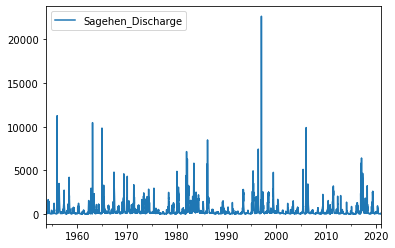

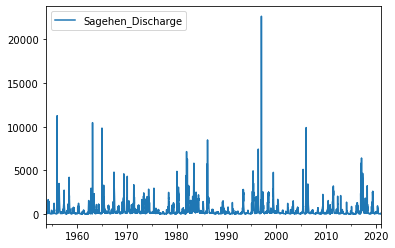

In [98]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Discharge unit should be L/s

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*28.3  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'Discharge') 
Discharge = copy.deepcopy(df)
Discharge.plot()

### Read Meteorology data

In [8]:
data1 = pd.read_csv(path + 'df539_daily_lvl1B.csv',
                    header = 0,index_col = 'Date',parse_dates = True, infer_datetime_format = True)
data1.index = data1.index.rename('DateTime')
data1.head(2)

SWE (mm)  Snow Depth (cm)  Precip (mm)  Avg Air Temp (C)  \
DateTime                                                               
1978-10-01         0              NaN            0               NaN   
1978-10-02         0              NaN            0               NaN   

            Max Air Temp (C)  Min Air Temp (C)  
DateTime                                        
1978-10-01               NaN               NaN  
1978-10-02               NaN               NaN

In [9]:
data2 = pd.read_csv(path + 'df539_daily_lvl2.csv',
                    header = 0,index_col = 'Date',parse_dates = True, infer_datetime_format = True)
data2.index = data2.index.rename('DateTime')
data2.head(2)

swe_mm_539  sd_cm_539  percip_accum_mm_539  avgtemp_C_539  \
DateTime                                                                
1978-10-01         0.0        NaN                  0.0            NaN   
1978-10-02         0.0        NaN                  0.0            NaN   

            maxtemp_C_539  mintemp_C_539 swe_mm_539_flags sd_cm_539_flags  \
DateTime                                                                    
1978-10-01            NaN            NaN                M             NaN   
1978-10-02            NaN            NaN                M             NaN   

           percip_accum_mm_539_flags avgtemp_C_539_flags maxtemp_C_539_flags  \
DateTime                                                                       
1978-10-01                         M                 NaN                 NaN   
1978-10-02                         M                 NaN                 NaN   

           mintemp_C_539_flags swe_mm_539_inst sd_cm_539_inst  \
DateTime                                                        
1978-10-01                 NaN               M            NaN   
1978-10-02                 NaN               M            NaN   

           percip_accum_mm_539_inst avgtemp_C_539_inst maxtemp_C_539_inst  \
DateTime                                                                    
1978-10-01                        M                NaN                NaN   
1978-10-02                        M                NaN                NaN   

           mintemp_C_539_inst  
DateTime                       
1978-10-01                NaN  
1978-10-02                NaN

In [10]:
data3 = pd.read_csv(path + 'df540_daily_lvl1B.csv',
                    header = 0,index_col = 'Date',parse_dates = True, infer_datetime_format = True)
data3.index = data3.index.rename('DateTime')
data3.head(2)

Snow Depth (cm)  SWE (mm)  Precip (mm)  Avg Air Temp (C)  \
DateTime                                                               
1980-10-01              NaN       NaN            0               NaN   
1980-10-02              NaN       NaN            0               NaN   

            Max Air Temp (C)  Min Air Temp (C)  
DateTime                                        
1980-10-01               NaN               NaN  
1980-10-02               NaN               NaN

In [11]:
data4 = pd.read_csv(path + 'df540_daily_lvl2.csv',
                    header = 0,index_col = 'Unnamed: 0',parse_dates = True, infer_datetime_format = True)

data4.index = data4.index.rename('DateTime')
data4.head(2)

swe_mm_540  sd_cm_540  precip_accum_mm_540  avgtemp_C_540  \
DateTime                                                                
1980-10-01         NaN        NaN                  0.0            NaN   
1980-10-02         NaN        NaN                  0.0            NaN   

            maxtemp_C_540  mintemp_C_540 swe_mm_540.1 sd_cm_540.1  \
DateTime                                                            
1980-10-01            NaN            NaN          NaN         NaN   
1980-10-02            NaN            NaN          NaN         NaN   

           precip_accum_mm_540_flags avgtemp_C_540.1 maxtemp_C_540.1  \
DateTime                                                               
1980-10-01                         M             NaN             NaN   
1980-10-02                         M             NaN             NaN   

           mintemp_C_540.1 swe_mm_540.2 sd_cm_540.2 precip_accum_mm_540_inst  \
DateTime                                                                       
1980-10-01             NaN          NaN         NaN                        M   
1980-10-02             NaN          NaN         NaN                        M   

           avgtemp_C_540.2 maxtemp_C_540.2 mintemp_C_540.2  
DateTime                                                    
1980-10-01             NaN             NaN             NaN  
1980-10-02             NaN             NaN             NaN

In [12]:
data5 = pd.read_csv(path + 'df541_daily_lvl1B.csv',
                    header = 0,index_col = 'Date',parse_dates = True, infer_datetime_format = True)
data5.index = data5.index.rename('DateTime')
data5.head(2)


SWE (mm)  Snow Depth (cm)  Precip (mm)  Avg Air Temp (C)  \
DateTime                                                               
1978-10-01         0              NaN            0               NaN   
1978-10-02         0              NaN            0               NaN   

            Max Air Temp (C)  Min Air Temp (C)  
DateTime                                        
1978-10-01               NaN               NaN  
1978-10-02               NaN               NaN

In [13]:
data6 = pd.read_csv(path + 'df541_daily_lvl2.csv',
                    header = 0,index_col = 'Unnamed: 0',parse_dates = True, infer_datetime_format = True)

data6.index = data6.index.rename('DateTime')
data6.head(3)


swe_mm_541  sd_cm_541  percip_accum_mm_541  avgtemp_C_541  \
DateTime                                                                
1978-10-01         0.0        NaN                  0.0            NaN   
1978-10-02         0.0        NaN                  0.0            NaN   
1978-10-03         0.0        NaN                  0.0            NaN   

            maxtemp_C_541  mintemp_C_541 swe_mm_541_flags sd_cm_541_flags  \
DateTime                                                                    
1978-10-01            NaN            NaN                M             NaN   
1978-10-02            NaN            NaN                M             NaN   
1978-10-03            NaN            NaN                M             NaN   

           percip_accum_mm_541_flags avgtemp_C_541_flags maxtemp_C_541_flags  \
DateTime                                                                       
1978-10-01                         M                 NaN                 NaN   
1978-10-02                         M                 NaN                 NaN   
1978-10-03                         M                 NaN                 NaN   

           mintemp_C_541_flags swe_mm_541_inst sd_cm_541_inst  \
DateTime                                                        
1978-10-01                 NaN               M            NaN   
1978-10-02                 NaN               M            NaN   
1978-10-03                 NaN               M            NaN   

           percip_accum_mm_541_inst avgtemp_C_541_inst maxtemp_C_541_inst  \
DateTime                                                                    
1978-10-01                        M                NaN                NaN   
1978-10-02                        M                NaN                NaN   
1978-10-03                        M                NaN                NaN   

           mintemp_C_541_inst  
DateTime                       
1978-10-01                NaN  
1978-10-02                NaN  
1978-10-03                NaN

In [14]:
data7 = pd.read_csv(path + 'dfwrcc_daily_lvl1.csv',
                    header = 0,index_col = 'DATE',parse_dates = True, infer_datetime_format = True)
data7.index = data7.index.rename('DateTime')
data7.head(2)

DATE.1  Snow Depth (cm)  Avg Air Temp (C)  Max Air Temp (C)  \
DateTime                                                                      
1956-10-01  1956-10-01              0.0               NaN               NaN   
1956-10-02  1956-10-02              0.0               NaN               NaN   

            Min Air Temp (C)  Precip (mm)  
DateTime                                   
1956-10-01               NaN       0.0000  
1956-10-02               NaN       0.4108

In [15]:
data8 = pd.read_csv(path + 'dfwrcc_daily_lvl2.csv',
                    header = 0,index_col = 'Unnamed: 0',parse_dates = True, infer_datetime_format = True)
data8.index = data8.index.rename('DateTime')
data8.head(2)

Unnamed: 0.1  sd_cm_wrcc  avgtemp_C_wrcc  maxtemp_C_wrcc  \
DateTime                                                              
1956-10-01   1956-10-01         0.0             NaN             NaN   
1956-10-02   1956-10-02         0.0             NaN             NaN   

            mintemp_C_wrcc  precip_inc_mm_wrcc sd_cm_wrcc_flags  \
DateTime                                                          
1956-10-01             NaN              0.0000                M   
1956-10-02             NaN              0.4108                M   

           avgtemp_C_wrcc_flags maxtemp_C_wrcc_flags mintemp_C_wrcc_flags  \
DateTime                                                                    
1956-10-01                  NaN                  NaN                  NaN   
1956-10-02                  NaN                  NaN                  NaN   

           precip_accum_mm_wrcc_flags sd_cm_wrcc_flags_inst  \
DateTime                                                      
1956-10-01                        NaN                     M   
1956-10-02                        NaN                     M   

           avgtemp_C_wrcc_flags_inst maxtemp_C_wrcc_flags_inst  \
DateTime                                                         
1956-10-01                       NaN                       NaN   
1956-10-02                       NaN                       NaN   

           mintemp_C_wrcc_flags_inst precip_accum_mm_wrcc_flags_inst  
DateTime                                                              
1956-10-01                       NaN                             NaN  
1956-10-02                       NaN                             NaN

In [16]:
data9 = pd.read_csv(path + 'tower1_lvl1.csv',
                    header = 0,index_col = 'Timestamp',parse_dates = True, infer_datetime_format = True)
data9.index = data9.index.rename('DateTime')
data9.head(2)

Air Temp C 100ft Sage1 [Sagehen1]  \
DateTime                                                 
2009-10-27 10:00:00                          -0.345200   
2009-10-27 11:00:00                           0.397833   

                     Air Temp C 25ft Sage1 [Sagehen1]  \
DateTime                                                
2009-10-27 10:00:00                         -0.589200   
2009-10-27 11:00:00                         -0.137667   

                     Rel Hum 25ft Sage1 [Sagehen1]  \
DateTime                                             
2009-10-27 10:00:00                      48.322000   
2009-10-27 11:00:00                      43.891667   

                     Rel Hum 100ft Sage1 [Sagehen1]  \
DateTime                                              
2009-10-27 10:00:00                       47.712000   
2009-10-27 11:00:00                       42.933333   

                     Wind Spd MS 100ft Sage1 [Sagehen1]  \
DateTime                                                  
2009-10-27 10:00:00                                 NaN   
2009-10-27 11:00:00                                 NaN   

                     Wind Spd Max MS 25ft Sage1 [Sagehen1]  \
DateTime                                                     
2009-10-27 10:00:00                                    NaN   
2009-10-27 11:00:00                                    NaN   

                     Wind Spd Max MS 100ft Sage1 [Sagehen1]  \
DateTime                                                      
2009-10-27 10:00:00                                     NaN   
2009-10-27 11:00:00                                     NaN   

                     Solar Radiation Avg Wm2 Sage1 [Sagehen1]  \
DateTime                                                        
2009-10-27 10:00:00                                342.000068   
2009-10-27 11:00:00                                661.389021   

                     BP mb 25ft Sage1 [Sagehen1]  
DateTime                                          
2009-10-27 10:00:00                          NaN  
2009-10-27 11:00:00                          NaN

In [17]:
data10 = pd.read_csv(path + 'tower1_lvl2.csv',
                    header = 0,index_col = 'Unnamed: 0',parse_dates = True, infer_datetime_format = True)
data10.index = data10.index.rename('DateTime')
data10.head(2)

avgtemp_C_t1_25ft  avgtemp_C_t1_100ft  RHall_t1_25  \
DateTime                                                                  
2009-01-02 00:00:00           3.414898            2.415003    91.344294   
2009-01-02 01:00:00           5.121099            4.259749    84.000659   

                     RHall_t1_100  maxws_ms_t1_25ft  avgws_ms_t1_100ft  \
DateTime                                                                 
2009-01-02 00:00:00     97.908636               NaN                NaN   
2009-01-02 01:00:00     90.054196               NaN                NaN   

                     maxws_ms_t1_100ft  srad_Wm2_  BP_mbar_t1  \
DateTime                                                        
2009-01-02 00:00:00                NaN        0.0         NaN   
2009-01-02 01:00:00                NaN        0.0         NaN   

                    avgtemp_C_t1_25ft_flag  ... BP_mbar_t1_flag  \
DateTime                                    ...                   
2009-01-02 00:00:00                    EHC  ...             NaN   
2009-01-02 01:00:00                    EHC  ...             NaN   

                    avgtemp_C_t1_25ft_inst avgtemp_C_t1_100ft_inst  \
DateTime                                                             
2009-01-02 00:00:00         avgtemp_tower1          avgtemp_tower1   
2009-01-02 01:00:00         avgtemp_tower1          avgtemp_tower1   

                    RHall_t1_25_inst RHall_t1_100_inst maxws_ms_t1_25ft_inst  \
DateTime                                                                       
2009-01-02 00:00:00         avgRH_t1          avgRH_t1                   NaN   
2009-01-02 01:00:00         avgRH_t1          avgRH_t1                   NaN   

                    avgws_ms_t1_100ft_inst maxws_ms_t1_100ft_inst  \
DateTime                                                            
2009-01-02 00:00:00                    NaN                    NaN   
2009-01-02 01:00:00                    NaN                    NaN   

                    srad_Wm2__inst BP_mbar_t1_inst  
DateTime                                            
2009-01-02 00:00:00      srad_wrcc             NaN  
2009-01-02 01:00:00      srad_wrcc             NaN  

[2 rows x 27 columns]

In [18]:
data11 = pd.read_csv(path + 'tower3_lvl1.csv',
                    header = 0,index_col = 'Timestamp',parse_dates = True, infer_datetime_format = True)
data11.index = data11.index.rename('DateTime')
data11.head(2)

Air Temp C Avg 25ft Sage3 [Sagehen3]  \
DateTime                                                    
2009-12-23 10:00:00                                0.1910   
2009-12-23 11:00:00                                1.1645   

                     Air Temp C Avg 100ft Sage3 [Sagehen3]  \
DateTime                                                     
2009-12-23 10:00:00                               1.204000   
2009-12-23 11:00:00                               1.575833   

                     Air Temp C Max 25ft Sage3 [Sagehen3]  \
DateTime                                                    
2009-12-23 10:00:00                              0.421000   
2009-12-23 11:00:00                              1.343333   

                     Air Temp C Max 100ft Sage3 [Sagehen3]  \
DateTime                                                     
2009-12-23 10:00:00                               1.378000   
2009-12-23 11:00:00                               1.810167   

                     Air Temp C Min 25ft Sage3 [Sagehen3]  \
DateTime                                                    
2009-12-23 10:00:00                              0.082000   
2009-12-23 11:00:00                              0.939833   

                     Air Temp C Min 100ft Sage3 [Sagehen3]  \
DateTime                                                     
2009-12-23 10:00:00                                  1.141   
2009-12-23 11:00:00                                  1.355   

                     Rel Hum 25ft Sage3 [Sagehen3]  \
DateTime                                             
2009-12-23 10:00:00                      35.980000   
2009-12-23 11:00:00                      33.583333   

                     Rel Hum 100ft Sage3 [Sagehen3]  \
DateTime                                              
2009-12-23 10:00:00                       25.250000   
2009-12-23 11:00:00                       27.261667   

                     Rel Hum Max 25ft Sage3 [Sagehen3]  \
DateTime                                                 
2009-12-23 10:00:00                          50.910000   
2009-12-23 11:00:00                          40.936667   

                     Rel Hum Max 100ft Sage3 [Sagehen3]  \
DateTime                                                  
2009-12-23 10:00:00                           30.410000   
2009-12-23 11:00:00                           30.798333   

                     Rel Hum Min 25ft Sage3 [Sagehen3]  \
DateTime                                                 
2009-12-23 10:00:00                              28.98   
2009-12-23 11:00:00                              27.23   

                     Rel Hum Min 100ft Sage3 [Sagehen3]  \
DateTime                                                  
2009-12-23 10:00:00                              24.090   
2009-12-23 11:00:00                              23.005   

                     Wind Spd MS 25ft Sage3 [Sagehen3]  WS_ms_25ft_Max  \
DateTime                                                                 
2009-12-23 10:00:00                           0.383000             NaN   
2009-12-23 11:00:00                           0.496333             NaN   

                     Wind Spd MS 100ft Sage3 [Sagehen3]  WS_ms_100ft_Max  \
DateTime                                                                   
2009-12-23 10:00:00                            0.536000              NaN   
2009-12-23 11:00:00                            1.371833              NaN   

                     Solar Radiation Avg Wm2 Sage3 [Sagehen3]  BP_mbar_Avg  
DateTime                                                                    
2009-12-23 10:00:00                                670.001340          NaN  
2009-12-23 11:00:00                                763.057082          NaN

In [19]:
data12 = pd.read_csv(path + 'tower3_lvl2.csv',
                    header = 0,index_col = 'Unnamed: 0',parse_dates = True, infer_datetime_format = True)
data12.index = data12.index.rename('DateTime')
data12.head(2)

avgtemp_C_t3_25ft  avgtemp_C_t3_100ft  maxtemp_C_t3_25ft  \
DateTime                                                                        
2009-12-23 00:00:00         -12.375434           -7.991635         -10.904494   
2009-12-23 01:00:00         -13.269934           -8.745630         -12.176123   

                     maxtemp_C_t3_100ft  mintemp_C_t3_25ft  \
DateTime                                                     
2009-12-23 00:00:00           -6.989968         -11.190642   
2009-12-23 01:00:00           -8.081347         -12.451323   

                     mintemp_C_t3_100ft  avgRH_t3_25  avgRH_t3_100  \
DateTime                                                             
2009-12-23 00:00:00           -7.346182    82.656370     71.445068   
2009-12-23 01:00:00           -8.424651    83.937774     72.525176   

                     maxRH_t3_25  maxRH_t3_100  ...  avgRH_t3_25_inst  \
DateTime                                        ...                     
2009-12-23 00:00:00    83.917839     73.020076  ...       avgRH_t1_25   
2009-12-23 01:00:00    85.175926     74.097767  ...       avgRH_t1_25   

                     avgRH_t3_100_inst  maxRH_t3_25_inst  minRH_t3_25_inst  \
DateTime                                                                     
2009-12-23 00:00:00        avgRH_t3_25       avgRH_t3_25       avgRH_t3_25   
2009-12-23 01:00:00        avgRH_t3_25       avgRH_t3_25       avgRH_t3_25   

                     avgws_ms_t3_25ft_inst  maxws_ms_t3_25ft_inst  \
DateTime                                                            
2009-12-23 00:00:00          tower1_100avg           tower1_25max   
2009-12-23 01:00:00          tower1_100avg           tower1_25max   

                     avgws_ms_t3_100ft_inst  maxws_ms_t3_100ft_inst  \
DateTime                                                              
2009-12-23 00:00:00            tower3_25avg            tower3_25max   
2009-12-23 01:00:00            tower3_25avg            tower3_25max   

                    srad_Wm2__inst BP_mbar_t3_inst  
DateTime                                            
2009-12-23 00:00:00      srad_wrcc         BPdf_t1  
2009-12-23 01:00:00      srad_wrcc         BPdf_t1  

[2 rows x 50 columns]

In [20]:
data13 = pd.read_csv(path + 'tower4_lvl1.csv',
                    header = 0,index_col = 'Timestamp',parse_dates = True, infer_datetime_format = True)
data13.index = data13.index.rename('DateTime')
data13.head(2)

Air Temp C Avg 25ft Sage4 [Sagehen4]  \
DateTime                                                    
2009-12-23 12:00:00                              1.941667   
2009-12-23 13:00:00                              2.459000   

                     Air Temp C Avg 100ft Sage4 [Sagehen4]  \
DateTime                                                     
2009-12-23 12:00:00                               0.990500   
2009-12-23 13:00:00                               0.670333   

                     Air Temp C Max 25ft Sage4 [Sagehen4]  \
DateTime                                                    
2009-12-23 12:00:00                              2.378333   
2009-12-23 13:00:00                              2.654500   

                     Air Temp C Min 25ft Sage4 [Sagehen4]  \
DateTime                                                    
2009-12-23 12:00:00                              1.502167   
2009-12-23 13:00:00                              2.253500   

                     Rel Hum 25ft Sage4 [Sagehen4]  \
DateTime                                             
2009-12-23 12:00:00                      17.875000   
2009-12-23 13:00:00                      26.133333   

                     Rel Hum Max 25ft Sage4 [Sagehen4]  \
DateTime                                                 
2009-12-23 12:00:00                          22.685000   
2009-12-23 13:00:00                          28.296667   

                     Rel Hum Min 25ft Sage4 [Sagehen4]  \
DateTime                                                 
2009-12-23 12:00:00                          11.661667   
2009-12-23 13:00:00                          22.880000   

                     Wind Spd MS 25ft Sage4 [Sagehen4]  \
DateTime                                                 
2009-12-23 12:00:00                           0.755000   
2009-12-23 13:00:00                           0.492667   

                     Wind Spd MS 100ft Sage4 [Sagehen4]  WS_ms_25ft_Max  \
DateTime                                                                  
2009-12-23 12:00:00                                 NaN             NaN   
2009-12-23 13:00:00                                 NaN             NaN   

                     WS_ms_100ft_Max  \
DateTime                               
2009-12-23 12:00:00              NaN   
2009-12-23 13:00:00              NaN   

                     Solar Radiation Avg Wm2 Sage4 [Sagehen4]  BP_mbar_Avg  
DateTime                                                                    
2009-12-23 12:00:00                                923.057402          NaN  
2009-12-23 13:00:00                                836.946118          NaN

In [21]:
data14 = pd.read_csv(path + 'tower4_lvl2.csv',
                    header = 0,index_col = 'Unnamed: 0',parse_dates = True, infer_datetime_format = True)
data14.index = data14.index.rename('DateTime')
data14.head(2)

avgtemp_C_t4_25ft  avgtemp_C_t4_100ft  maxtemp_C_t4_25ft  \
DateTime                                                                        
2009-12-23 00:00:00          -9.534160          -11.478195          -8.531821   
2009-12-23 01:00:00         -10.310051          -12.223852          -9.650125   

                     mintemp_C_t4_100ft  avgRH_t4_25  maxRH_t4_25  \
DateTime                                                            
2009-12-23 00:00:00           -8.771497    69.767785    71.011921   
2009-12-23 01:00:00           -9.880008    70.843416    72.080879   

                     minRH_t4_25  avgws_ms_t4_25ft  maxws_ms_t4_25ft  \
DateTime                                                               
2009-12-23 00:00:00    68.421734          1.882888               NaN   
2009-12-23 01:00:00    69.500398          1.708107               NaN   

                     avgws_ms_t4_100ft  ...  mintemp_C_t4_100ft_inst  \
DateTime                                ...                            
2009-12-23 00:00:00           3.640587  ...             tower3_25min   
2009-12-23 01:00:00           3.364137  ...             tower3_25min   

                     avgRH_t4_25_inst  maxRH_t4_25_inst minRH_t4_25_inst  \
DateTime                                                                   
2009-12-23 00:00:00      avgRH_t3_100       avgRH_t4_25      avgRH_t4_25   
2009-12-23 01:00:00      avgRH_t3_100       avgRH_t4_25      avgRH_t4_25   

                    avgws_ms_t4_25ft_inst maxws_ms_t4_25ft_inst  \
DateTime                                                          
2009-12-23 00:00:00          tower3_25avg                   NaN   
2009-12-23 01:00:00          tower3_25avg                   NaN   

                    avgws_ms_t4_100ft_inst maxws_ms_t4_100ft_inst  \
DateTime                                                            
2009-12-23 00:00:00           tower4_25avg           tower4_25max   
2009-12-23 01:00:00           tower4_25avg           tower4_25max   

                    srad_Wm2__inst BP_mbar_t4_inst  
DateTime                                            
2009-12-23 00:00:00        srad_t3         BPdf_t3  
2009-12-23 01:00:00        srad_t3         BPdf_t3  

[2 rows x 39 columns]

### 2. Precipitation

In [22]:
ppt8 = data8[['precip_inc_mm_wrcc']]
ppt8.columns = ['wrcclvl2_Precipitation']
ppt8.head(2)

wrcclvl2_Precipitation
DateTime                          
1956-10-01                  0.0000
1956-10-02                  0.4108

In [23]:
ppt7 = data7[['Precip (mm)']]
ppt7.columns = ['wrcclvl1B_Precipitation']
ppt7.head(2)

wrcclvl1B_Precipitation
DateTime                           
1956-10-01                   0.0000
1956-10-02                   0.4108

In [24]:
ppt6 = data6[['percip_accum_mm_541']]
ppt6.columns = ['541lvl2_Precipitation']
ppt6=threC(ppt6,'Precipitation')
ppt6['541lvl2_Precipitation'][1:]=np.array(ppt6['541lvl2_Precipitation'])[1:]-np.array(ppt6['541lvl2_Precipitation'])[:-1] 
ppt6.head(2)

541lvl2_Precipitation
DateTime                         
1978-10-01                    0.0
1978-10-02                    0.0

In [25]:
ppt5 = data5[['Precip (mm)']]
ppt5.columns = ['541lvlB_Precipitation']
ppt5=threC(ppt5,'Precipitation')
ppt5['541lvlB_Precipitation'][1:]=np.array(ppt5['541lvlB_Precipitation'])[1:]-np.array(ppt5['541lvlB_Precipitation'])[:-1] 
ppt5.head(2)

541lvlB_Precipitation
DateTime                         
1978-10-01                    0.0
1978-10-02                    0.0

In [26]:
ppt4 = data4[['precip_accum_mm_540']]
ppt4.columns = ['540lvl2_Precipitation']
ppt4=threC(ppt4,'Precipitation')
ppt4['540lvl2_Precipitation'][1:]=np.array(ppt4['540lvl2_Precipitation'])[1:]-np.array(ppt4['540lvl2_Precipitation'])[:-1] 
ppt4.head(2)

540lvl2_Precipitation
DateTime                         
1980-10-01                    0.0
1980-10-02                    0.0

In [27]:
ppt3 = data3[['Precip (mm)']]
ppt3.columns = ['540lvlB_Precipitation']
ppt3=threC(ppt3,'Precipitation')
ppt3['540lvlB_Precipitation'][1:]=np.array(ppt3['540lvlB_Precipitation'])[1:]-np.array(ppt3['540lvlB_Precipitation'])[:-1] 
ppt3.head(2)

540lvlB_Precipitation
DateTime                         
1980-10-01                    0.0
1980-10-02                    0.0

In [28]:
ppt2 = data2[['percip_accum_mm_539']]
ppt2.columns = ['539lvl2_Precipitation']
ppt2=threC(ppt2,'Precipitation')
ppt2['539lvl2_Precipitation'][1:]=np.array(ppt2['539lvl2_Precipitation'])[1:]-np.array(ppt2['539lvl2_Precipitation'])[:-1] 
ppt2.head(2)

539lvl2_Precipitation
DateTime                         
1978-10-01                    0.0
1978-10-02                    0.0

In [29]:
ppt1 = data1[['Precip (mm)']]
ppt1.columns = ['539lvl1B_Precipitation']
ppt1=threC(ppt1,'Precipitation')
ppt1['539lvl1B_Precipitation'][1:]=np.array(ppt1['539lvl1B_Precipitation'])[1:]-np.array(ppt1['539lvl1B_Precipitation'])[:-1] 
ppt1.head(2)

539lvl1B_Precipitation
DateTime                          
1978-10-01                     0.0
1978-10-02                     0.0

In [30]:
df_lst=[ppt1,ppt2,ppt3,ppt4,ppt5,ppt6,ppt7,ppt8]
for df in df_lst:     
    df=threC(df,'Precipitation') # modify the dataframe and set unphysical values to NAN
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=1, func = "sum") 

539lvl1B_Precipitation
DateTime                          
1978-10-01                     0.0
1978-10-02                     0.0

(14245, 1)
1978-10-01 00:00:00 2017-09-30 00:00:00


539lvl2_Precipitation
DateTime                         
1978-10-01                    0.0
1978-10-02                    0.0

(14499, 1)
1978-10-01 00:00:00 2018-06-11 00:00:00


540lvlB_Precipitation
DateTime                         
1980-10-01                    0.0
1980-10-02                    0.0

(13514, 1)
1980-10-01 00:00:00 2017-09-30 00:00:00


540lvl2_Precipitation
DateTime                         
1980-10-01                    0.0
1980-10-02                    0.0

(13768, 1)
1980-10-01 00:00:00 NaT


541lvlB_Precipitation
DateTime                         
1978-10-01                    0.0
1978-10-02                    0.0

(14245, 1)
1978-10-01 00:00:00 2017-09-30 00:00:00


541lvl2_Precipitation
DateTime                         
1978-10-01                    0.0
1978-10-02                    0.0

(14499, 1)
1978-10-01 00:00:00 2018-06-11 00:00:00


wrcclvl1B_Precipitation
DateTime                           
1956-10-01                   0.0000
1956-10-02                   0.4108

(17926, 1)
1956-10-01 00:00:00 2007-06-30 00:00:00


wrcclvl2_Precipitation
DateTime                          
1956-10-01                  0.0000
1956-10-02                  0.4108

(18535, 1)
1956-10-01 00:00:00 2007-06-30 00:00:00
The final table is:


539lvl1B_Precipitation 539lvl2_Precipitation 540lvlB_Precipitation  \
1956-10-01                    NaN                   NaN                   NaN   
1956-10-02                    NaN                   NaN                   NaN   

           540lvl2_Precipitation 541lvlB_Precipitation 541lvl2_Precipitation  \
1956-10-01                   NaN                   NaN                   NaN   
1956-10-02                   NaN                   NaN                   NaN   

           wrcclvl1B_Precipitation wrcclvl2_Precipitation  
1956-10-01                       0                      0  
1956-10-02                  0.4108                 0.4108

539lvl1B_Precipitation 539lvl2_Precipitation 540lvlB_Precipitation  \
2018-06-10                    NaN                   NaN                   NaN   
2018-06-11                    NaN                   NaN                   NaN   

           540lvl2_Precipitation 541lvlB_Precipitation 541lvl2_Precipitation  \
2018-06-10                   NaN                   NaN                   NaN   
2018-06-11                   NaN                   NaN                   NaN   

           wrcclvl1B_Precipitation wrcclvl2_Precipitation  
2018-06-10                     NaN                    NaN  
2018-06-11                     NaN                    NaN

539lvl1B_Precipitation
539lvl2_Precipitation
540lvlB_Precipitation
540lvl2_Precipitation
541lvlB_Precipitation
541lvl2_Precipitation
wrcclvl1B_Precipitation
wrcclvl2_Precipitation


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

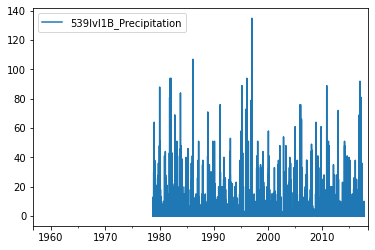

<Figure size 432x288 with 0 Axes>

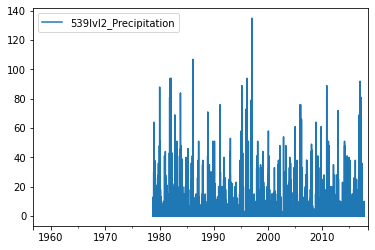

<Figure size 432x288 with 0 Axes>

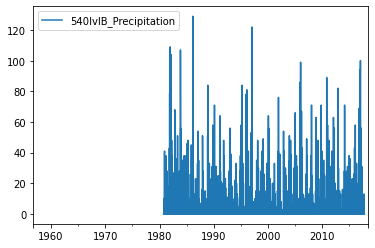

<Figure size 432x288 with 0 Axes>

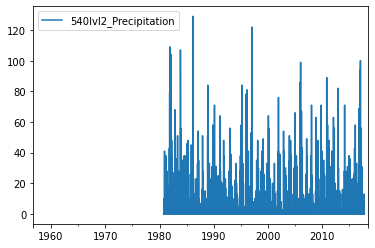

<Figure size 432x288 with 0 Axes>

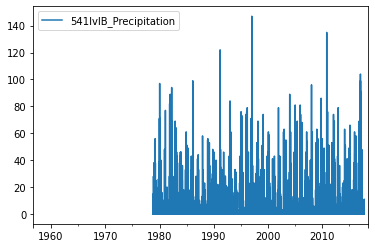

<Figure size 432x288 with 0 Axes>

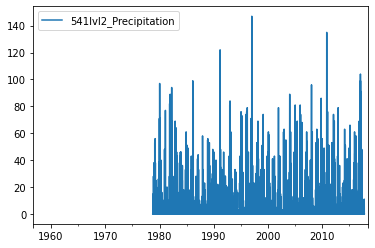

<Figure size 432x288 with 0 Axes>

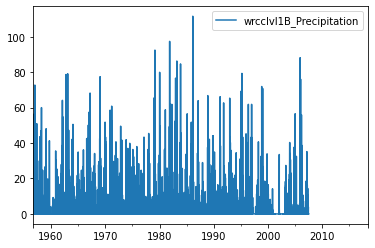

<Figure size 432x288 with 0 Axes>

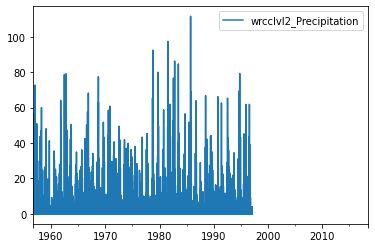

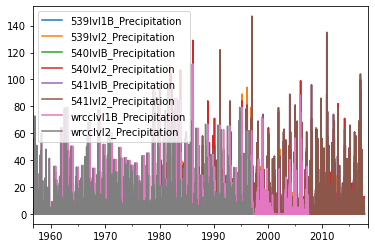

In [31]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Precipitation unit should be mm

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'Precipitation')     
Precipitation = copy.deepcopy(df)
Precipitation.plot()

### 3. Air Temperature

In [32]:
prep14=data14[['avgtemp_C_t4_25ft','avgtemp_C_t4_100ft']]
prep14.columns = ['tower4lvl2_AirTemperature_25ft','tower4lvl2_AirTemperature_100ft']
prep14.head(2)

tower4lvl2_AirTemperature_25ft  \
DateTime                                              
2009-12-23 00:00:00                       -9.534160   
2009-12-23 01:00:00                      -10.310051   

                     tower4lvl2_AirTemperature_100ft  
DateTime                                              
2009-12-23 00:00:00                       -11.478195  
2009-12-23 01:00:00                       -12.223852

In [33]:
prep13_1 = data13[['Air Temp C Avg 25ft Sage4 [Sagehen4]']]
prep13_1.columns = ['tower4lvl1_AirTemperature_25ft']

prep13_2 = data13[['Air Temp C Avg 100ft Sage4 [Sagehen4]']]
prep13_2.columns = ['tower4lvl1_AirTemperature_100ft']
prep13_2.head()

tower4lvl1_AirTemperature_100ft
DateTime                                            
2009-12-23 12:00:00                         0.990500
2009-12-23 13:00:00                         0.670333
2009-12-23 14:00:00                         1.045000
2009-12-23 15:00:00                         0.227000
2009-12-23 16:00:00                        -0.518833

In [34]:
prep12_1 = data12[['avgtemp_C_t3_25ft']]
prep12_1.columns = ['tower3lvl2_AirTemperature_25ft']
prep12_1.head(2)

prep12_2 = data12[['avgtemp_C_t3_100ft']]
prep12_2.columns = ['tower3lvl2_AirTemperature_100ft']
prep12_2.head(2)

tower3lvl2_AirTemperature_100ft
DateTime                                            
2009-12-23 00:00:00                        -7.991635
2009-12-23 01:00:00                        -8.745630

In [35]:
prep11_1 = data11[['Air Temp C Avg 25ft Sage3 [Sagehen3]']]
prep11_1.columns = ['tower3lvl1_AirTemperature_25ft']

prep11_2 = data11[['Air Temp C Avg 100ft Sage3 [Sagehen3]']]
prep11_2.columns = ['tower3lvl1_AirTemperature_100ft']
prep11_2.head()

tower3lvl1_AirTemperature_100ft
DateTime                                            
2009-12-23 10:00:00                         1.204000
2009-12-23 11:00:00                         1.575833
2009-12-23 12:00:00                         1.451500
2009-12-23 13:00:00                         1.727667
2009-12-23 14:00:00                         2.186833

In [36]:
prep10_1 = data10[['avgtemp_C_t1_25ft']]
prep10_1.columns = ['tower1lvl2_AirTemperature_25ft']
prep10_1.head(2)

prep10_2 = data10[['avgtemp_C_t1_100ft']]
prep10_2.columns = ['tower1lvl2_AirTemperature_100ft']
prep10_2.head(2)


tower1lvl2_AirTemperature_100ft
DateTime                                            
2009-01-02 00:00:00                         2.415003
2009-01-02 01:00:00                         4.259749

In [37]:
prep9_1 = data9[['Air Temp C 100ft Sage1 [Sagehen1]']]
prep9_1.columns = ['tower1lvl1_AirTemperature_100ft']
prep9_1.head(2)

prep9_2 = data9[['Air Temp C 25ft Sage1 [Sagehen1]']]
prep9_2.columns = ['tower1lvl1_AirTemperature_25ft']
prep9_2.head(2)


tower1lvl1_AirTemperature_25ft
DateTime                                           
2009-10-27 10:00:00                       -0.589200
2009-10-27 11:00:00                       -0.137667

In [38]:
prep8 = data8[['avgtemp_C_wrcc']]
prep8.columns = ['wrcclvl2_AirTemperature']
prep8.head(2)

wrcclvl2_AirTemperature
DateTime                           
1956-10-01                      NaN
1956-10-02                      NaN

In [39]:
prep7 = data7[['Avg Air Temp (C)']]
prep7.columns = ['wrcclvl1B_AirTemperature']
prep7.head(2)

wrcclvl1B_AirTemperature
DateTime                            
1956-10-01                       NaN
1956-10-02                       NaN

In [40]:
prep6 = data6[['avgtemp_C_541']]
prep6.columns = ['541lvl2_AirTemperature']
prep6.head(2)

541lvl2_AirTemperature
DateTime                          
1978-10-01                     NaN
1978-10-02                     NaN

In [41]:
prep5 = data5[['Avg Air Temp (C)']]
prep5.columns = ['541lvl1B_AirTemperature']
prep5.head(2)

541lvl1B_AirTemperature
DateTime                           
1978-10-01                      NaN
1978-10-02                      NaN

In [42]:
prep4 = data4[['avgtemp_C_540']]
prep4.columns = ['540lvl2_AirTemperature']
prep4.head(2)

540lvl2_AirTemperature
DateTime                          
1980-10-01                     NaN
1980-10-02                     NaN

In [43]:
prep3 = data3[['Avg Air Temp (C)']]
prep3.columns = ['540lvl1B_AirTemperature']
prep3.head(2)

540lvl1B_AirTemperature
DateTime                           
1980-10-01                      NaN
1980-10-02                      NaN

In [44]:
prep2 = data2[['avgtemp_C_539']]
prep2.columns = ['539lvl2_AirTemperature']
prep2.head(2)

539lvl2_AirTemperature
DateTime                          
1978-10-01                     NaN
1978-10-02                     NaN

In [45]:
prep1 = data1[['Avg Air Temp (C)']]
prep1.columns = ['539lvl1B_AirTemperature']
prep1.head(2)

539lvl1B_AirTemperature
DateTime                           
1978-10-01                      NaN
1978-10-02                      NaN

539lvl1B_AirTemperature
DateTime                           
1978-10-01                      NaN
1978-10-02                      NaN

(14245, 1)
1978-10-01 00:00:00 2017-09-30 00:00:00


539lvl2_AirTemperature
DateTime                          
1978-10-01                     NaN
1978-10-02                     NaN

(14499, 1)
1978-10-01 00:00:00 2018-06-11 00:00:00


540lvl1B_AirTemperature
DateTime                           
1980-10-01                      NaN
1980-10-02                      NaN

(13514, 1)
1980-10-01 00:00:00 2017-09-30 00:00:00


540lvl2_AirTemperature
DateTime                          
1980-10-01                     NaN
1980-10-02                     NaN

(13768, 1)
1980-10-01 00:00:00 NaT


541lvl1B_AirTemperature
DateTime                           
1978-10-01                      NaN
1978-10-02                      NaN

(14245, 1)
1978-10-01 00:00:00 2017-09-30 00:00:00


541lvl2_AirTemperature
DateTime                          
1978-10-01                     NaN
1978-10-02                     NaN

(14499, 1)
1978-10-01 00:00:00 2018-06-11 00:00:00


wrcclvl1B_AirTemperature
DateTime                            
1956-10-01                       NaN
1956-10-02                       NaN

(17926, 1)
1956-10-01 00:00:00 2007-06-30 00:00:00


wrcclvl2_AirTemperature
DateTime                           
1956-10-01                      NaN
1956-10-02                      NaN

(18535, 1)
1956-10-01 00:00:00 2007-06-30 00:00:00


tower1lvl1_AirTemperature_100ft
DateTime                                            
2009-10-27 10:00:00                        -0.345200
2009-10-27 11:00:00                         0.397833

(69111, 1)
2009-10-27 10:00:00 2017-09-15 00:00:00


tower1lvl1_AirTemperature_25ft
DateTime                                           
2009-10-27 10:00:00                       -0.589200
2009-10-27 11:00:00                       -0.137667

(69111, 1)
2009-10-27 10:00:00 2017-09-15 00:00:00


tower1lvl2_AirTemperature_25ft
DateTime                                           
2009-01-02 00:00:00                        3.414898
2009-01-02 01:00:00                        5.121099

(82741, 1)
2009-01-02 00:00:00 2018-06-11 12:00:00


tower1lvl2_AirTemperature_100ft
DateTime                                            
2009-01-02 00:00:00                         2.415003
2009-01-02 01:00:00                         4.259749

(82741, 1)
2009-01-02 00:00:00 2018-06-11 12:00:00


tower3lvl1_AirTemperature_25ft
DateTime                                           
2009-12-23 10:00:00                          0.1910
2009-12-23 11:00:00                          1.1645

(68103, 1)
2009-12-23 10:00:00 2017-09-30 00:00:00


tower3lvl1_AirTemperature_100ft
DateTime                                            
2009-12-23 10:00:00                         1.204000
2009-12-23 11:00:00                         1.575833

(68103, 1)
2009-12-23 10:00:00 2017-09-30 00:00:00


tower3lvl2_AirTemperature_25ft
DateTime                                           
2009-12-23 00:00:00                      -12.375434
2009-12-23 01:00:00                      -13.269934

(74221, 1)
2009-12-23 00:00:00 2018-06-11 12:00:00


tower3lvl2_AirTemperature_100ft
DateTime                                            
2009-12-23 00:00:00                        -7.991635
2009-12-23 01:00:00                        -8.745630

(74221, 1)
2009-12-23 00:00:00 2018-06-11 12:00:00


tower4lvl1_AirTemperature_25ft
DateTime                                           
2009-12-23 12:00:00                        1.941667
2009-12-23 13:00:00                        2.459000

(68124, 1)
2009-12-23 12:00:00 2017-09-30 23:00:00


tower4lvl1_AirTemperature_100ft
DateTime                                            
2009-12-23 12:00:00                         0.990500
2009-12-23 13:00:00                         0.670333

(68124, 1)
2009-12-23 12:00:00 2017-09-30 23:00:00


tower4lvl2_AirTemperature_25ft  \
DateTime                                              
2009-12-23 00:00:00                       -9.534160   
2009-12-23 01:00:00                      -10.310051   

                     tower4lvl2_AirTemperature_100ft  
DateTime                                              
2009-12-23 00:00:00                       -11.478195  
2009-12-23 01:00:00                       -12.223852

(74221, 2)
2009-12-23 00:00:00 2018-06-11 12:00:00
['tower1lvl1_AirTemperature_100ft', datetime.date(2009, 11, 13)]
nan ratio is 0.041666666666666664 , groupby value is -4.445159419739128
['tower1lvl1_AirTemperature_100ft', datetime.date(2009, 12, 6)]
nan ratio is 0.08333333333333333 , groupby value is -9.795446969545456
['tower1lvl1_AirTemperature_100ft', datetime.date(2010, 11, 16)]
nan ratio is 0.041666666666666664 , groupby value is 0.24902173899999996
['tower1lvl1_AirTemperature_100ft', datetime.date(2010, 11, 28)]
nan ratio is 0.041666666666666664 , groupby value is -10.640485507347826
['tower1lvl1_AirTemperature_100ft', datetime.date(2013, 11, 15)]
nan ratio is 0.041666666666666664 , groupby value is -0.3162115942173914
['tower1lvl1_AirTemperature_100ft', datetime.date(2013, 12, 7)]
nan ratio is 0.041666666666666664 , groupby value is -10.765217390999998
['tower1lvl1_AirTemperature_100ft', datetime.date(2017, 2, 24)]
nan ratio is 0.08333333333333333 , groupby value is -9.2149848

['tower4lvl1_AirTemperature_100ft', datetime.date(2011, 5, 11)]
nan ratio is 0.08333333333333333 , groupby value is 6.9409204545909065
['tower4lvl1_AirTemperature_100ft', datetime.date(2012, 6, 13)]
nan ratio is 0.08333333333333333 , groupby value is 14.80094697
['tower4lvl1_AirTemperature_100ft', datetime.date(2015, 12, 18)]
nan ratio is 0.041666666666666664 , groupby value is -0.6921123188695653
['tower4lvl1_AirTemperature_100ft', datetime.date(2015, 12, 24)]
nan ratio is 0.041666666666666664 , groupby value is -8.806657970434783
['tower4lvl1_AirTemperature_100ft', datetime.date(2016, 3, 28)]
nan ratio is 0.041666666666666664 , groupby value is -10.408058695956523
['tower4lvl1_AirTemperature_100ft', datetime.date(2016, 5, 20)]
nan ratio is 0.041666666666666664 , groupby value is -6.321244927478261
['tower4lvl1_AirTemperature_100ft', datetime.date(2017, 2, 21)]
nan ratio is 0.041666666666666664 , groupby value is -9.130326087130435
['tower4lvl2_AirTemperature_100ft', datetime.date(201

539lvl1B_AirTemperature 539lvl2_AirTemperature  \
1956-10-01                     NaN                    NaN   
1956-10-02                     NaN                    NaN   

           540lvl1B_AirTemperature 540lvl2_AirTemperature  \
1956-10-01                     NaN                    NaN   
1956-10-02                     NaN                    NaN   

           541lvl1B_AirTemperature 541lvl2_AirTemperature  \
1956-10-01                     NaN                    NaN   
1956-10-02                     NaN                    NaN   

           wrcclvl1B_AirTemperature wrcclvl2_AirTemperature  \
1956-10-01                      NaN                     NaN   
1956-10-02                      NaN                     NaN   

           tower1lvl1_AirTemperature_100ft tower1lvl1_AirTemperature_25ft  \
1956-10-01                             NaN                            NaN   
1956-10-02                             NaN                            NaN   

           tower1lvl2_AirTemperature_25ft tower1lvl2_AirTemperature_100ft  \
1956-10-01                            NaN                             NaN   
1956-10-02                            NaN                             NaN   

           tower3lvl1_AirTemperature_25ft tower3lvl1_AirTemperature_100ft  \
1956-10-01                            NaN                             NaN   
1956-10-02                            NaN                             NaN   

           tower3lvl2_AirTemperature_25ft tower3lvl2_AirTemperature_100ft  \
1956-10-01                            NaN                             NaN   
1956-10-02                            NaN                             NaN   

           tower4lvl1_AirTemperature_25ft tower4lvl1_AirTemperature_100ft  \
1956-10-01                            NaN                             NaN   
1956-10-02                            NaN                             NaN   

           tower4lvl2_AirTemperature_25ft tower4lvl2_AirTemperature_100ft  
1956-10-01                            NaN                             NaN  
1956-10-02                            NaN                             NaN

539lvl1B_AirTemperature 539lvl2_AirTemperature  \
2018-06-10                     NaN                    NaN   
2018-06-11                     NaN                    NaN   

           540lvl1B_AirTemperature 540lvl2_AirTemperature  \
2018-06-10                     NaN                    NaN   
2018-06-11                     NaN                    NaN   

           541lvl1B_AirTemperature 541lvl2_AirTemperature  \
2018-06-10                     NaN                    NaN   
2018-06-11                     NaN                    NaN   

           wrcclvl1B_AirTemperature wrcclvl2_AirTemperature  \
2018-06-10                      NaN                     NaN   
2018-06-11                      NaN                     NaN   

           tower1lvl1_AirTemperature_100ft tower1lvl1_AirTemperature_25ft  \
2018-06-10                             NaN                            NaN   
2018-06-11                             NaN                            NaN   

           tower1lvl2_AirTemperature_25ft tower1lvl2_AirTemperature_100ft  \
2018-06-10                            NaN                             NaN   
2018-06-11                            NaN                             NaN   

           tower3lvl1_AirTemperature_25ft tower3lvl1_AirTemperature_100ft  \
2018-06-10                            NaN                             NaN   
2018-06-11                            NaN                             NaN   

           tower3lvl2_AirTemperature_25ft tower3lvl2_AirTemperature_100ft  \
2018-06-10                            NaN                             NaN   
2018-06-11                            NaN                             NaN   

           tower4lvl1_AirTemperature_25ft tower4lvl1_AirTemperature_100ft  \
2018-06-10                            NaN                             NaN   
2018-06-11                            NaN                             NaN   

           tower4lvl2_AirTemperature_25ft tower4lvl2_AirTemperature_100ft  
2018-06-10                        7.24776                         1.29811  
2018-06-11                            NaN                             NaN

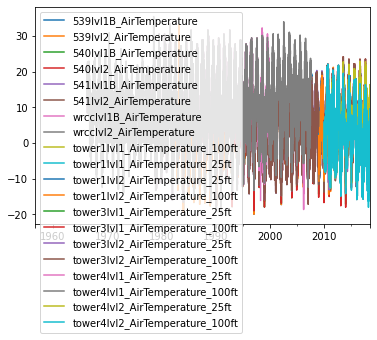

In [46]:
df_lst = [prep1,prep2,prep3,prep4,prep5,prep6,prep7,prep8,prep9_1,prep9_2,prep10_1,prep10_2,prep11_1,prep11_2,prep12_1,prep12_2,prep13_1,prep13_2,prep14]
for df in df_lst:
    df = threC(df,'AirTemperature')
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 
prep.plot()

539lvl1B_AirTemperature
539lvl2_AirTemperature
540lvl1B_AirTemperature
540lvl2_AirTemperature
541lvl1B_AirTemperature
541lvl2_AirTemperature
wrcclvl1B_AirTemperature
wrcclvl2_AirTemperature
tower1lvl1_AirTemperature_100ft
tower1lvl1_AirTemperature_25ft
tower1lvl2_AirTemperature_25ft
tower1lvl2_AirTemperature_100ft
tower3lvl1_AirTemperature_25ft
tower3lvl1_AirTemperature_100ft
tower3lvl2_AirTemperature_25ft
tower3lvl2_AirTemperature_100ft
tower4lvl1_AirTemperature_25ft
tower4lvl1_AirTemperature_100ft
tower4lvl2_AirTemperature_25ft
tower4lvl2_AirTemperature_100ft


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

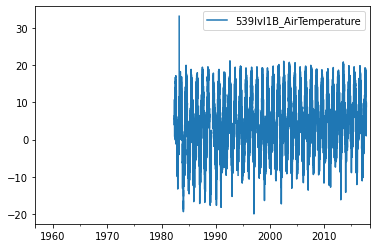

<Figure size 432x288 with 0 Axes>

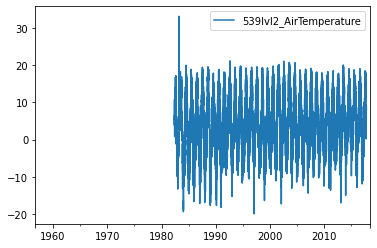

<Figure size 432x288 with 0 Axes>

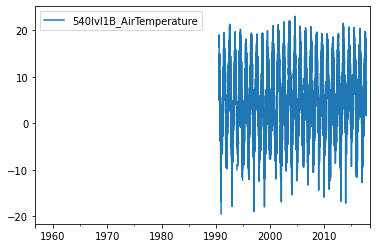

<Figure size 432x288 with 0 Axes>

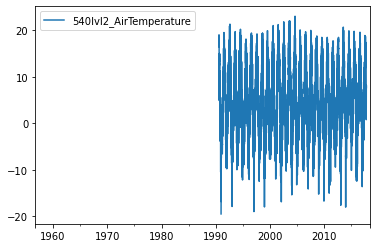

<Figure size 432x288 with 0 Axes>

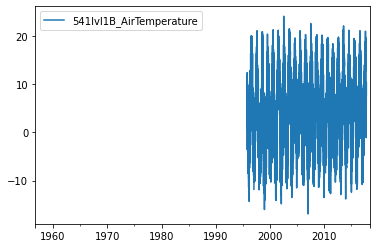

<Figure size 432x288 with 0 Axes>

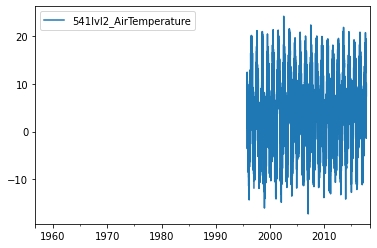

<Figure size 432x288 with 0 Axes>

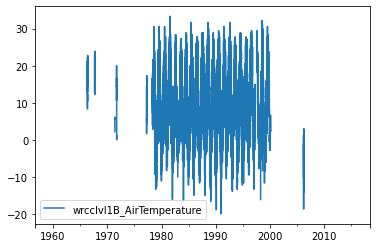

<Figure size 432x288 with 0 Axes>

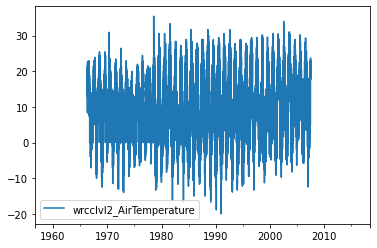

<Figure size 432x288 with 0 Axes>

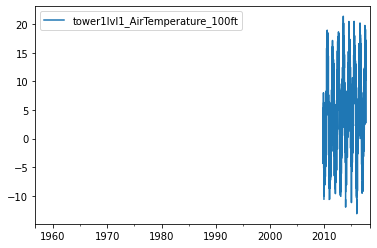

<Figure size 432x288 with 0 Axes>

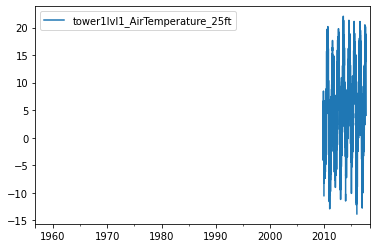

<Figure size 432x288 with 0 Axes>

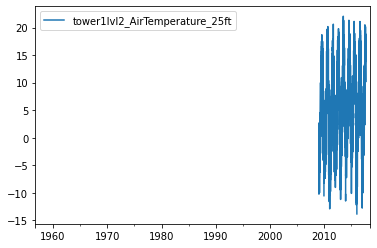

<Figure size 432x288 with 0 Axes>

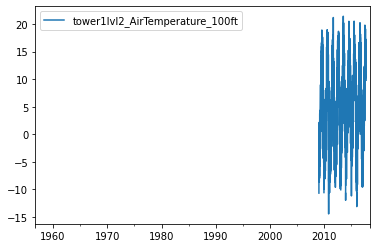

<Figure size 432x288 with 0 Axes>

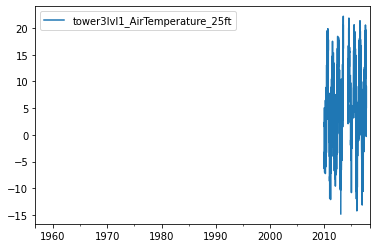

<Figure size 432x288 with 0 Axes>

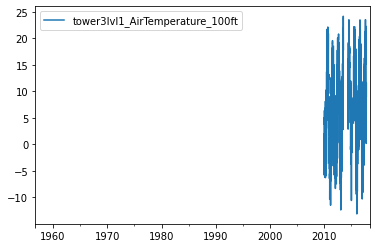

<Figure size 432x288 with 0 Axes>

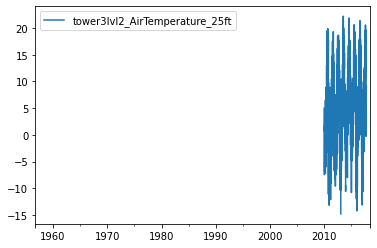

<Figure size 432x288 with 0 Axes>

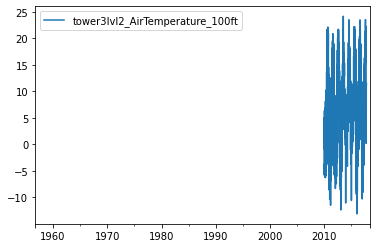

<Figure size 432x288 with 0 Axes>

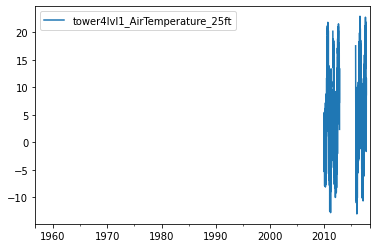

<Figure size 432x288 with 0 Axes>

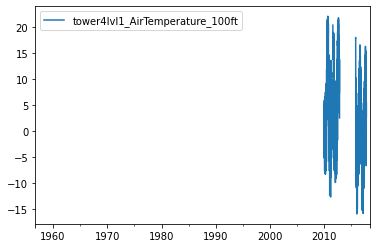

<Figure size 432x288 with 0 Axes>

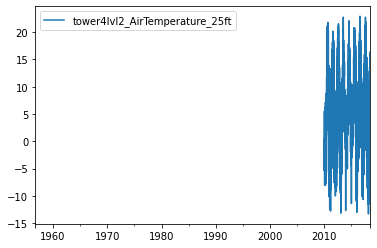

<Figure size 432x288 with 0 Axes>

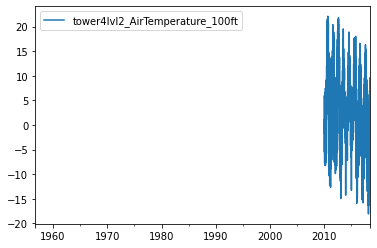

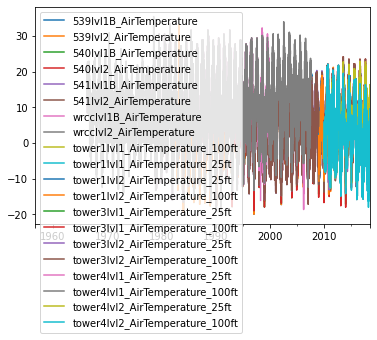

In [47]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Air Temperature unit should be Degree celsius

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'AirTemperature')   
AirTemperature = copy.deepcopy(df)
AirTemperature.plot()

### 4. Solar Radiation

In [48]:
prep14 = data14[['srad_Wm2_']]
prep14.columns = ['tower4lvl2_SolarRadiation']
prep14.head(2)

tower4lvl2_SolarRadiation
DateTime                                      
2009-12-23 00:00:00                        0.0
2009-12-23 01:00:00                        0.0

In [49]:
prep13 = data13[['Solar Radiation Avg Wm2 Sage4 [Sagehen4]']]
prep13.columns = ['tower4lvl1_SolarRadiation']
prep13.head()

tower4lvl1_SolarRadiation
DateTime                                      
2009-12-23 12:00:00                 923.057402
2009-12-23 13:00:00                 836.946118
2009-12-23 14:00:00                 622.501245
2009-12-23 15:00:00                 274.167215
2009-12-23 16:00:00                  17.500035

In [50]:
prep12 = data12[['srad_Wm2_']]
prep12.columns = ['tower3lvl2_SolarRadiation']
prep12.head(2)

tower3lvl2_SolarRadiation
DateTime                                      
2009-12-23 00:00:00                        0.0
2009-12-23 01:00:00                        0.0

In [51]:
prep11 = data11[['Solar Radiation Avg Wm2 Sage3 [Sagehen3]']]
prep11.columns = ['tower3lvl1_SolarRadiation']

In [52]:
prep10 = data10[['srad_Wm2_']]
prep10.columns = ['tower1lvl2_SolarRadiation']
prep10.head(2)

tower1lvl2_SolarRadiation
DateTime                                      
2009-01-02 00:00:00                        0.0
2009-01-02 01:00:00                        0.0

In [53]:
prep9 = data9[['Solar Radiation Avg Wm2 Sage1 [Sagehen1]']]
prep9.columns = ['tower1lvl1_SolarRadiation']
prep9.head(2)

tower1lvl1_SolarRadiation
DateTime                                      
2009-10-27 10:00:00                 342.000068
2009-10-27 11:00:00                 661.389021

tower1lvl1_SolarRadiation
DateTime                                      
2009-10-27 10:00:00                 342.000068
2009-10-27 11:00:00                 661.389021

(69111, 1)
2009-10-27 10:00:00 2017-09-15 00:00:00


tower1lvl2_SolarRadiation
DateTime                                      
2009-01-02 00:00:00                        0.0
2009-01-02 01:00:00                        0.0

(82741, 1)
2009-01-02 00:00:00 2018-06-11 12:00:00


tower3lvl1_SolarRadiation
DateTime                                      
2009-12-23 10:00:00                 670.001340
2009-12-23 11:00:00                 763.057082

(68103, 1)
2009-12-23 10:00:00 2017-09-30 00:00:00


tower3lvl2_SolarRadiation
DateTime                                      
2009-12-23 00:00:00                        0.0
2009-12-23 01:00:00                        0.0

(74221, 1)
2009-12-23 00:00:00 2018-06-11 12:00:00


tower4lvl1_SolarRadiation
DateTime                                      
2009-12-23 12:00:00                 923.057402
2009-12-23 13:00:00                 836.946118

(68124, 1)
2009-12-23 12:00:00 2017-09-30 23:00:00


tower4lvl2_SolarRadiation
DateTime                                      
2009-12-23 00:00:00                        0.0
2009-12-23 01:00:00                        0.0

(74221, 1)
2009-12-23 00:00:00 2018-06-11 12:00:00
['tower1lvl1_SolarRadiation', datetime.date(2009, 11, 13)]
nan ratio is 0.041666666666666664 , groupby value is 139.9396415175652
['tower1lvl1_SolarRadiation', datetime.date(2010, 3, 14)]
nan ratio is 0.041666666666666664 , groupby value is 216.59424622882608
['tower1lvl1_SolarRadiation', datetime.date(2010, 3, 15)]
nan ratio is 0.041666666666666664 , groupby value is 339.2271209813043
['tower1lvl1_SolarRadiation', datetime.date(2010, 3, 16)]
nan ratio is 0.08333333333333333 , groupby value is 291.5404623774091
['tower1lvl1_SolarRadiation', datetime.date(2010, 3, 18)]
nan ratio is 0.08333333333333333 , groupby value is 309.28036491986364
['tower1lvl1_SolarRadiation', datetime.date(2010, 3, 22)]
nan ratio is 0.041666666666666664 , groupby value is 327.65707041160874
['tower1lvl1_SolarRadiation', datetime.date(2010, 3, 24)]
nan ratio is 0.08333333333333333 , groupby value is 277.2273281725909
['tower1lvl1_SolarRadiation', datetime.date(2

['tower1lvl1_SolarRadiation', datetime.date(2011, 7, 6)]
nan ratio is 0.08333333333333333 , groupby value is 405.55563671377274
['tower1lvl1_SolarRadiation', datetime.date(2011, 7, 15)]
nan ratio is 0.08333333333333333 , groupby value is 411.42685001818177
['tower1lvl1_SolarRadiation', datetime.date(2011, 9, 4)]
nan ratio is 0.08333333333333333 , groupby value is 333.76269299090916
['tower1lvl1_SolarRadiation', datetime.date(2011, 9, 8)]
nan ratio is 0.041666666666666664 , groupby value is 305.4589982708696
['tower1lvl1_SolarRadiation', datetime.date(2011, 9, 9)]
nan ratio is 0.08333333333333333 , groupby value is 305.12632368031814
['tower1lvl1_SolarRadiation', datetime.date(2011, 9, 10)]
nan ratio is 0.041666666666666664 , groupby value is 237.59666588695654
['tower1lvl1_SolarRadiation', datetime.date(2011, 9, 12)]
nan ratio is 0.041666666666666664 , groupby value is 165.7850573059565
['tower1lvl1_SolarRadiation', datetime.date(2011, 9, 13)]
nan ratio is 0.08333333333333333 , groupby

['tower1lvl1_SolarRadiation', datetime.date(2013, 7, 15)]
nan ratio is 0.08333333333333333 , groupby value is 402.4369491484545
['tower1lvl1_SolarRadiation', datetime.date(2013, 7, 23)]
nan ratio is 0.041666666666666664 , groupby value is 239.86719773347824
['tower1lvl1_SolarRadiation', datetime.date(2013, 7, 24)]
nan ratio is 0.041666666666666664 , groupby value is 416.4614359652175
['tower1lvl1_SolarRadiation', datetime.date(2013, 7, 25)]
nan ratio is 0.08333333333333333 , groupby value is 305.5556166270909
['tower1lvl1_SolarRadiation', datetime.date(2013, 7, 27)]
nan ratio is 0.08333333333333333 , groupby value is 404.10361618936366
['tower1lvl1_SolarRadiation', datetime.date(2013, 8, 8)]
nan ratio is 0.08333333333333333 , groupby value is 373.5733070740909
['tower1lvl1_SolarRadiation', datetime.date(2013, 8, 22)]
nan ratio is 0.041666666666666664 , groupby value is 386.4976618172174
['tower1lvl1_SolarRadiation', datetime.date(2013, 8, 23)]
nan ratio is 0.041666666666666664 , groupb

['tower1lvl1_SolarRadiation', datetime.date(2014, 9, 22)]
nan ratio is 0.08333333333333333 , groupby value is 271.51520580604546
['tower1lvl1_SolarRadiation', datetime.date(2015, 3, 13)]
nan ratio is 0.041666666666666664 , groupby value is 330.9590034317392
['tower1lvl1_SolarRadiation', datetime.date(2015, 3, 19)]
nan ratio is 0.08333333333333333 , groupby value is 314.73491147559093
['tower1lvl1_SolarRadiation', datetime.date(2015, 3, 25)]
nan ratio is 0.08333333333333333 , groupby value is 328.04299494390904
['tower1lvl1_SolarRadiation', datetime.date(2015, 3, 26)]
nan ratio is 0.08333333333333333 , groupby value is 346.9445138636363
['tower1lvl1_SolarRadiation', datetime.date(2015, 4, 6)]
nan ratio is 0.08333333333333333 , groupby value is 333.8005718319545
['tower1lvl1_SolarRadiation', datetime.date(2015, 4, 9)]
nan ratio is 0.08333333333333333 , groupby value is 366.9192653545454
['tower1lvl1_SolarRadiation', datetime.date(2015, 4, 12)]
nan ratio is 0.08333333333333333 , groupby v

['tower1lvl1_SolarRadiation', datetime.date(2016, 7, 28)]
nan ratio is 0.08333333333333333 , groupby value is 400.2652315787727
['tower1lvl1_SolarRadiation', datetime.date(2016, 8, 16)]
nan ratio is 0.08333333333333333 , groupby value is 264.91166918059093
['tower1lvl1_SolarRadiation', datetime.date(2016, 8, 17)]
nan ratio is 0.041666666666666664 , groupby value is 296.7874989663913
['tower1lvl1_SolarRadiation', datetime.date(2016, 8, 18)]
nan ratio is 0.08333333333333333 , groupby value is 270.98490265786364
['tower1lvl1_SolarRadiation', datetime.date(2016, 8, 19)]
nan ratio is 0.08333333333333333 , groupby value is 351.0733025604545
['tower1lvl1_SolarRadiation', datetime.date(2016, 8, 20)]
nan ratio is 0.08333333333333333 , groupby value is 330.71976314531815
['tower1lvl1_SolarRadiation', datetime.date(2016, 8, 21)]
nan ratio is 0.041666666666666664 , groupby value is 298.0676924827391
['tower1lvl1_SolarRadiation', datetime.date(2016, 9, 2)]
nan ratio is 0.041666666666666664 , groupb

['tower1lvl2_SolarRadiation', datetime.date(2009, 2, 26)]
nan ratio is 0.041666666666666664 , groupby value is 226.08700173913044
['tower1lvl2_SolarRadiation', datetime.date(2009, 3, 5)]
nan ratio is 0.041666666666666664 , groupby value is 174.13046960869565
['tower1lvl2_SolarRadiation', datetime.date(2009, 3, 8)]
nan ratio is 0.041666666666666664 , groupby value is 308.84064147826086
['tower1lvl2_SolarRadiation', datetime.date(2009, 3, 9)]
nan ratio is 0.041666666666666664 , groupby value is 310.2174533478261
['tower1lvl2_SolarRadiation', datetime.date(2009, 3, 10)]
nan ratio is 0.08333333333333333 , groupby value is 282.12126854545454
['tower1lvl2_SolarRadiation', datetime.date(2009, 3, 11)]
nan ratio is 0.08333333333333333 , groupby value is 286.666724
['tower1lvl2_SolarRadiation', datetime.date(2009, 3, 12)]
nan ratio is 0.08333333333333333 , groupby value is 293.4091495909091
['tower1lvl2_SolarRadiation', datetime.date(2009, 3, 13)]
nan ratio is 0.08333333333333333 , groupby value

['tower1lvl2_SolarRadiation', datetime.date(2010, 8, 7)]
nan ratio is 0.08333333333333333 , groupby value is 387.5884614181818
['tower1lvl2_SolarRadiation', datetime.date(2010, 8, 8)]
nan ratio is 0.08333333333333333 , groupby value is 237.29802726818187
['tower1lvl2_SolarRadiation', datetime.date(2010, 8, 21)]
nan ratio is 0.08333333333333333 , groupby value is 395.68189736377275
['tower1lvl2_SolarRadiation', datetime.date(2010, 8, 28)]
nan ratio is 0.08333333333333333 , groupby value is 290.68187631195457
['tower1lvl2_SolarRadiation', datetime.date(2010, 9, 9)]
nan ratio is 0.041666666666666664 , groupby value is 313.0556182029131
['tower1lvl2_SolarRadiation', datetime.date(2010, 9, 14)]
nan ratio is 0.08333333333333333 , groupby value is 336.04804700604546
['tower1lvl2_SolarRadiation', datetime.date(2010, 9, 15)]
nan ratio is 0.08333333333333333 , groupby value is 318.3839020712273
['tower1lvl2_SolarRadiation', datetime.date(2010, 9, 16)]
nan ratio is 0.08333333333333333 , groupby v

['tower1lvl2_SolarRadiation', datetime.date(2012, 8, 4)]
nan ratio is 0.041666666666666664 , groupby value is 393.4662622868262
['tower1lvl2_SolarRadiation', datetime.date(2012, 8, 13)]
nan ratio is 0.08333333333333333 , groupby value is 180.05054107909095
['tower1lvl2_SolarRadiation', datetime.date(2012, 8, 17)]
nan ratio is 0.041666666666666664 , groupby value is 220.13289427247818
['tower1lvl2_SolarRadiation', datetime.date(2012, 8, 18)]
nan ratio is 0.041666666666666664 , groupby value is 267.8986043029131
['tower1lvl2_SolarRadiation', datetime.date(2012, 8, 25)]
nan ratio is 0.08333333333333333 , groupby value is 398.3081604225454
['tower1lvl2_SolarRadiation', datetime.date(2012, 9, 7)]
nan ratio is 0.08333333333333333 , groupby value is 343.6743111894091
['tower1lvl2_SolarRadiation', datetime.date(2012, 9, 8)]
nan ratio is 0.041666666666666664 , groupby value is 356.41311478695656
['tower1lvl2_SolarRadiation', datetime.date(2012, 9, 9)]
nan ratio is 0.08333333333333333 , groupby 

['tower1lvl2_SolarRadiation', datetime.date(2014, 3, 13)]
nan ratio is 0.041666666666666664 , groupby value is 348.9251905957827
['tower1lvl2_SolarRadiation', datetime.date(2014, 3, 15)]
nan ratio is 0.041666666666666664 , groupby value is 346.7512770942174
['tower1lvl2_SolarRadiation', datetime.date(2014, 3, 17)]
nan ratio is 0.041666666666666664 , groupby value is 358.5628736623043
['tower1lvl2_SolarRadiation', datetime.date(2014, 3, 18)]
nan ratio is 0.08333333333333333 , groupby value is 320.87127626804545
['tower1lvl2_SolarRadiation', datetime.date(2014, 3, 19)]
nan ratio is 0.041666666666666664 , groupby value is 354.5652883217391
['tower1lvl2_SolarRadiation', datetime.date(2014, 3, 20)]
nan ratio is 0.08333333333333333 , groupby value is 310.4924863905909
['tower1lvl2_SolarRadiation', datetime.date(2014, 3, 22)]
nan ratio is 0.08333333333333333 , groupby value is 325.80814600590907
['tower1lvl2_SolarRadiation', datetime.date(2014, 3, 30)]
nan ratio is 0.041666666666666664 , grou

['tower1lvl2_SolarRadiation', datetime.date(2015, 6, 27)]
nan ratio is 0.08333333333333333 , groupby value is 418.34604326804543
['tower1lvl2_SolarRadiation', datetime.date(2015, 6, 29)]
nan ratio is 0.041666666666666664 , groupby value is 476.23197935621727
['tower1lvl2_SolarRadiation', datetime.date(2015, 6, 30)]
nan ratio is 0.041666666666666664 , groupby value is 448.92521058117387
['tower1lvl2_SolarRadiation', datetime.date(2015, 7, 2)]
nan ratio is 0.041666666666666664 , groupby value is 286.70295589539137
['tower1lvl2_SolarRadiation', datetime.date(2015, 7, 8)]
nan ratio is 0.041666666666666664 , groupby value is 197.5966578923043
['tower1lvl2_SolarRadiation', datetime.date(2015, 7, 10)]
nan ratio is 0.08333333333333333 , groupby value is 340.92178540468177
['tower1lvl2_SolarRadiation', datetime.date(2015, 7, 12)]
nan ratio is 0.041666666666666664 , groupby value is 295.5435374030435
['tower1lvl2_SolarRadiation', datetime.date(2015, 7, 17)]
nan ratio is 0.041666666666666664 , gr

['tower1lvl2_SolarRadiation', datetime.date(2017, 3, 11)]
nan ratio is 0.041666666666666664 , groupby value is 283.4783175813044
['tower1lvl2_SolarRadiation', datetime.date(2017, 3, 12)]
nan ratio is 0.041666666666666664 , groupby value is 341.0991021
['tower1lvl2_SolarRadiation', datetime.date(2017, 3, 13)]
nan ratio is 0.08333333333333333 , groupby value is 307.52531400590914
['tower1lvl2_SolarRadiation', datetime.date(2017, 3, 14)]
nan ratio is 0.08333333333333333 , groupby value is 278.35864157563645
['tower1lvl2_SolarRadiation', datetime.date(2017, 3, 15)]
nan ratio is 0.041666666666666664 , groupby value is 257.53628339421743
['tower1lvl2_SolarRadiation', datetime.date(2017, 3, 17)]
nan ratio is 0.041666666666666664 , groupby value is 359.5290574143478
['tower1lvl2_SolarRadiation', datetime.date(2017, 3, 19)]
nan ratio is 0.041666666666666664 , groupby value is 293.9493341492609
['tower1lvl2_SolarRadiation', datetime.date(2017, 3, 23)]
nan ratio is 0.08333333333333333 , groupby v

['tower3lvl1_SolarRadiation', datetime.date(2010, 7, 9)]
nan ratio is 0.08333333333333333 , groupby value is 327.2733818290909
['tower3lvl1_SolarRadiation', datetime.date(2010, 8, 8)]
nan ratio is 0.041666666666666664 , groupby value is 299.5175072447826
['tower3lvl1_SolarRadiation', datetime.date(2010, 9, 13)]
nan ratio is 0.041666666666666664 , groupby value is 320.36295955234783
['tower3lvl1_SolarRadiation', datetime.date(2010, 9, 15)]
nan ratio is 0.08333333333333333 , groupby value is 338.81380895754546
['tower3lvl1_SolarRadiation', datetime.date(2010, 9, 16)]
nan ratio is 0.08333333333333333 , groupby value is 332.52591756363637
['tower3lvl1_SolarRadiation', datetime.date(2010, 9, 17)]
nan ratio is 0.08333333333333333 , groupby value is 300.7329247319546
['tower3lvl1_SolarRadiation', datetime.date(2010, 9, 18)]
nan ratio is 0.08333333333333333 , groupby value is 330.4047012395455
['tower3lvl1_SolarRadiation', datetime.date(2010, 9, 19)]
nan ratio is 0.08333333333333333 , groupby 

['tower3lvl1_SolarRadiation', datetime.date(2013, 2, 18)]
nan ratio is 0.041666666666666664 , groupby value is 194.43275599565217
['tower3lvl1_SolarRadiation', datetime.date(2013, 3, 9)]
nan ratio is 0.041666666666666664 , groupby value is 326.09968600117395
['tower3lvl1_SolarRadiation', datetime.date(2013, 3, 11)]
nan ratio is 0.041666666666666664 , groupby value is 338.16492757695653
['tower3lvl1_SolarRadiation', datetime.date(2013, 3, 13)]
nan ratio is 0.08333333333333333 , groupby value is 273.52327430168174
['tower3lvl1_SolarRadiation', datetime.date(2013, 3, 14)]
nan ratio is 0.041666666666666664 , groupby value is 309.54168185652173
['tower3lvl1_SolarRadiation', datetime.date(2013, 3, 16)]
nan ratio is 0.08333333333333333 , groupby value is 272.0965037696819
['tower3lvl1_SolarRadiation', datetime.date(2013, 3, 18)]
nan ratio is 0.041666666666666664 , groupby value is 321.54653682900005
['tower3lvl1_SolarRadiation', datetime.date(2013, 3, 21)]
nan ratio is 0.041666666666666664 , 

['tower3lvl1_SolarRadiation', datetime.date(2016, 4, 14)]
nan ratio is 0.041666666666666664 , groupby value is 301.8846617391305
['tower3lvl1_SolarRadiation', datetime.date(2016, 4, 21)]
nan ratio is 0.041666666666666664 , groupby value is 359.10699840578263
['tower3lvl1_SolarRadiation', datetime.date(2016, 4, 24)]
nan ratio is 0.041666666666666664 , groupby value is 339.03449449273916
['tower3lvl1_SolarRadiation', datetime.date(2016, 4, 26)]
nan ratio is 0.041666666666666664 , groupby value is 347.6818547666521
['tower3lvl1_SolarRadiation', datetime.date(2016, 5, 1)]
nan ratio is 0.041666666666666664 , groupby value is 348.5997310186957
['tower3lvl1_SolarRadiation', datetime.date(2016, 5, 2)]
nan ratio is 0.041666666666666664 , groupby value is 381.9210536579565
['tower3lvl1_SolarRadiation', datetime.date(2016, 5, 15)]
nan ratio is 0.041666666666666664 , groupby value is 344.445133332
['tower3lvl1_SolarRadiation', datetime.date(2016, 5, 16)]
nan ratio is 0.041666666666666664 , groupby

['tower3lvl2_SolarRadiation', datetime.date(2010, 3, 13)]
nan ratio is 0.041666666666666664 , groupby value is 281.64307536231877
['tower3lvl2_SolarRadiation', datetime.date(2010, 3, 14)]
nan ratio is 0.041666666666666664 , groupby value is 347.9717104347826
['tower3lvl2_SolarRadiation', datetime.date(2010, 3, 15)]
nan ratio is 0.08333333333333333 , groupby value is 308.73799121212124
['tower3lvl2_SolarRadiation', datetime.date(2010, 3, 16)]
nan ratio is 0.08333333333333333 , groupby value is 306.62940113636364
['tower3lvl2_SolarRadiation', datetime.date(2010, 3, 20)]
nan ratio is 0.041666666666666664 , groupby value is 341.437880942029
['tower3lvl2_SolarRadiation', datetime.date(2010, 3, 22)]
nan ratio is 0.08333333333333333 , groupby value is 282.96773765151516
['tower3lvl2_SolarRadiation', datetime.date(2010, 3, 24)]
nan ratio is 0.08333333333333333 , groupby value is 295.36675234848485
['tower3lvl2_SolarRadiation', datetime.date(2010, 3, 28)]
nan ratio is 0.08333333333333333 , grou

['tower3lvl2_SolarRadiation', datetime.date(2011, 6, 28)]
nan ratio is 0.041666666666666664 , groupby value is 296.5102548550725
['tower3lvl2_SolarRadiation', datetime.date(2011, 7, 15)]
nan ratio is 0.08333333333333333 , groupby value is 421.2740868011613
['tower3lvl2_SolarRadiation', datetime.date(2011, 7, 31)]
nan ratio is 0.08333333333333333 , groupby value is 374.31919781453195
['tower3lvl2_SolarRadiation', datetime.date(2011, 9, 4)]
nan ratio is 0.08333333333333333 , groupby value is 353.9618973514998
['tower3lvl2_SolarRadiation', datetime.date(2011, 9, 5)]
nan ratio is 0.08333333333333333 , groupby value is 329.4816283010899
['tower3lvl2_SolarRadiation', datetime.date(2011, 9, 9)]
nan ratio is 0.041666666666666664 , groupby value is 358.8775293478261
['tower3lvl2_SolarRadiation', datetime.date(2011, 9, 10)]
nan ratio is 0.041666666666666664 , groupby value is 243.27343340579702
['tower3lvl2_SolarRadiation', datetime.date(2011, 9, 12)]
nan ratio is 0.041666666666666664 , groupby 

['tower3lvl2_SolarRadiation', datetime.date(2013, 9, 7)]
nan ratio is 0.08333333333333333 , groupby value is 357.89539921977644
['tower3lvl2_SolarRadiation', datetime.date(2013, 9, 9)]
nan ratio is 0.08333333333333333 , groupby value is 357.6661555834002
['tower3lvl2_SolarRadiation', datetime.date(2013, 9, 10)]
nan ratio is 0.08333333333333333 , groupby value is 366.28131699249883
['tower3lvl2_SolarRadiation', datetime.date(2013, 9, 11)]
nan ratio is 0.041666666666666664 , groupby value is 296.64259632181313
['tower3lvl2_SolarRadiation', datetime.date(2013, 9, 15)]
nan ratio is 0.08333333333333333 , groupby value is 341.95023057175064
['tower3lvl2_SolarRadiation', datetime.date(2013, 9, 16)]
nan ratio is 0.08333333333333333 , groupby value is 340.9186341982767
['tower3lvl2_SolarRadiation', datetime.date(2013, 9, 17)]
nan ratio is 0.08333333333333333 , groupby value is 340.07807418936653
['tower3lvl2_SolarRadiation', datetime.date(2013, 9, 18)]
nan ratio is 0.08333333333333333 , groupby

['tower3lvl2_SolarRadiation', datetime.date(2015, 6, 27)]
nan ratio is 0.08333333333333333 , groupby value is 430.6448006818182
['tower3lvl2_SolarRadiation', datetime.date(2015, 7, 3)]
nan ratio is 0.08333333333333333 , groupby value is 440.2029006060606
['tower3lvl2_SolarRadiation', datetime.date(2015, 7, 5)]
nan ratio is 0.08333333333333333 , groupby value is 454.00343325757586
['tower3lvl2_SolarRadiation', datetime.date(2015, 7, 7)]
nan ratio is 0.041666666666666664 , groupby value is 270.60440594202896
['tower3lvl2_SolarRadiation', datetime.date(2015, 7, 10)]
nan ratio is 0.041666666666666664 , groupby value is 455.13376050724645
['tower3lvl2_SolarRadiation', datetime.date(2015, 7, 12)]
nan ratio is 0.041666666666666664 , groupby value is 352.875101884058
['tower3lvl2_SolarRadiation', datetime.date(2015, 7, 17)]
nan ratio is 0.08333333333333333 , groupby value is 377.3618658333333
['tower3lvl2_SolarRadiation', datetime.date(2015, 7, 19)]
nan ratio is 0.08333333333333333 , groupby v

['tower3lvl2_SolarRadiation', datetime.date(2017, 8, 2)]
nan ratio is 0.08333333333333333 , groupby value is 228.4600528787879
['tower3lvl2_SolarRadiation', datetime.date(2017, 8, 4)]
nan ratio is 0.041666666666666664 , groupby value is 410.7496137681161
['tower3lvl2_SolarRadiation', datetime.date(2017, 8, 6)]
nan ratio is 0.041666666666666664 , groupby value is 393.6360529710146
['tower3lvl2_SolarRadiation', datetime.date(2017, 8, 8)]
nan ratio is 0.08333333333333333 , groupby value is 375.79620613636365
['tower3lvl2_SolarRadiation', datetime.date(2017, 8, 14)]
nan ratio is 0.08333333333333333 , groupby value is 268.68740606060607
['tower3lvl2_SolarRadiation', datetime.date(2017, 8, 16)]
nan ratio is 0.08333333333333333 , groupby value is 260.49294522727274
['tower3lvl2_SolarRadiation', datetime.date(2017, 8, 17)]
nan ratio is 0.08333333333333333 , groupby value is 320.0890240151515
['tower3lvl2_SolarRadiation', datetime.date(2017, 8, 18)]
nan ratio is 0.08333333333333333 , groupby va

['tower4lvl1_SolarRadiation', datetime.date(2012, 2, 24)]
nan ratio is 0.041666666666666664 , groupby value is 325.6528252
['tower4lvl1_SolarRadiation', datetime.date(2012, 3, 22)]
nan ratio is 0.041666666666666664 , groupby value is 310.0972385957826
['tower4lvl1_SolarRadiation', datetime.date(2012, 4, 9)]
nan ratio is 0.041666666666666664 , groupby value is 412.8752218537827
['tower4lvl1_SolarRadiation', datetime.date(2012, 4, 17)]
nan ratio is 0.08333333333333333 , groupby value is 327.5511601622727
['tower4lvl1_SolarRadiation', datetime.date(2012, 4, 18)]
nan ratio is 0.041666666666666664 , groupby value is 336.01516478391295
['tower4lvl1_SolarRadiation', datetime.date(2012, 5, 3)]
nan ratio is 0.041666666666666664 , groupby value is 254.45703066795656
['tower4lvl1_SolarRadiation', datetime.date(2012, 8, 13)]
nan ratio is 0.041666666666666664 , groupby value is 216.84825977230435
['tower4lvl1_SolarRadiation', datetime.date(2012, 8, 18)]
nan ratio is 0.041666666666666664 , groupby v

['tower4lvl1_SolarRadiation', datetime.date(2017, 5, 14)]
nan ratio is 0.08333333333333333 , groupby value is 295.94756158940913
['tower4lvl1_SolarRadiation', datetime.date(2017, 6, 3)]
nan ratio is 0.08333333333333333 , groupby value is 363.08153428954546
['tower4lvl1_SolarRadiation', datetime.date(2017, 6, 8)]
nan ratio is 0.041666666666666664 , groupby value is 335.01274732026087
['tower4lvl1_SolarRadiation', datetime.date(2017, 6, 11)]
nan ratio is 0.08333333333333333 , groupby value is 372.72801819863633
['tower4lvl1_SolarRadiation', datetime.date(2017, 6, 12)]
nan ratio is 0.041666666666666664 , groupby value is 299.27596085795653
['tower4lvl1_SolarRadiation', datetime.date(2017, 8, 2)]
nan ratio is 0.08333333333333333 , groupby value is 242.6267479122728
['tower4lvl1_SolarRadiation', datetime.date(2017, 8, 6)]
nan ratio is 0.08333333333333333 , groupby value is 386.2633988057727
['tower4lvl1_SolarRadiation', datetime.date(2017, 8, 14)]
nan ratio is 0.08333333333333333 , groupby 

['tower4lvl2_SolarRadiation', datetime.date(2011, 6, 28)]
nan ratio is 0.08333333333333333 , groupby value is 283.71252839030797
['tower4lvl2_SolarRadiation', datetime.date(2011, 9, 7)]
nan ratio is 0.041666666666666664 , groupby value is 360.1094158695652
['tower4lvl2_SolarRadiation', datetime.date(2011, 9, 10)]
nan ratio is 0.08333333333333333 , groupby value is 241.28836136363634
['tower4lvl2_SolarRadiation', datetime.date(2011, 9, 13)]
nan ratio is 0.041666666666666664 , groupby value is 267.88700920289847
['tower4lvl2_SolarRadiation', datetime.date(2011, 9, 22)]
nan ratio is 0.08333333333333333 , groupby value is 359.1168798484848
['tower4lvl2_SolarRadiation', datetime.date(2011, 9, 25)]
nan ratio is 0.08333333333333333 , groupby value is 270.00053999999994
['tower4lvl2_SolarRadiation', datetime.date(2011, 9, 28)]
nan ratio is 0.08333333333333333 , groupby value is 338.7506775
['tower4lvl2_SolarRadiation', datetime.date(2011, 9, 29)]
nan ratio is 0.08333333333333333 , groupby valu

['tower4lvl2_SolarRadiation', datetime.date(2014, 3, 6)]
nan ratio is 0.08333333333333333 , groupby value is 211.4751377530303
['tower4lvl2_SolarRadiation', datetime.date(2014, 3, 14)]
nan ratio is 0.041666666666666664 , groupby value is 338.115252646652
['tower4lvl2_SolarRadiation', datetime.date(2014, 3, 25)]
nan ratio is 0.041666666666666664 , groupby value is 318.10624858870966
['tower4lvl2_SolarRadiation', datetime.date(2014, 4, 1)]
nan ratio is 0.041666666666666664 , groupby value is 171.53219184230082
['tower4lvl2_SolarRadiation', datetime.date(2014, 4, 2)]
nan ratio is 0.041666666666666664 , groupby value is 352.62318079656325
['tower4lvl2_SolarRadiation', datetime.date(2014, 4, 4)]
nan ratio is 0.041666666666666664 , groupby value is 365.0870027786791
['tower4lvl2_SolarRadiation', datetime.date(2014, 4, 11)]
nan ratio is 0.041666666666666664 , groupby value is 407.72995469602733
['tower4lvl2_SolarRadiation', datetime.date(2014, 4, 21)]
nan ratio is 0.08333333333333333 , groupb

['tower4lvl2_SolarRadiation', datetime.date(2015, 8, 8)]
nan ratio is 0.08333333333333333 , groupby value is 328.28555161417313
['tower4lvl2_SolarRadiation', datetime.date(2015, 9, 22)]
nan ratio is 0.08333333333333333 , groupby value is 332.8723818664773
['tower4lvl2_SolarRadiation', datetime.date(2015, 9, 25)]
nan ratio is 0.08333333333333333 , groupby value is 317.43840865713236
['tower4lvl2_SolarRadiation', datetime.date(2015, 9, 28)]
nan ratio is 0.041666666666666664 , groupby value is 306.12416728182126
['tower4lvl2_SolarRadiation', datetime.date(2015, 9, 29)]
nan ratio is 0.041666666666666664 , groupby value is 292.0666761767812
['tower4lvl2_SolarRadiation', datetime.date(2015, 10, 2)]
nan ratio is 0.08333333333333333 , groupby value is 292.4848019153558
['tower4lvl2_SolarRadiation', datetime.date(2015, 10, 3)]
nan ratio is 0.08333333333333333 , groupby value is 297.2450629833987
['tower4lvl2_SolarRadiation', datetime.date(2015, 10, 5)]
nan ratio is 0.041666666666666664 , groupb

['tower4lvl2_SolarRadiation', datetime.date(2018, 3, 7)]
nan ratio is 0.041666666666666664 , groupby value is 251.75171123188403
['tower4lvl2_SolarRadiation', datetime.date(2018, 4, 4)]
nan ratio is 0.041666666666666664 , groupby value is 364.17947231884057
['tower4lvl2_SolarRadiation', datetime.date(2018, 4, 5)]
nan ratio is 0.041666666666666664 , groupby value is 272.1140707971015
['tower4lvl2_SolarRadiation', datetime.date(2018, 4, 7)]
nan ratio is 0.041666666666666664 , groupby value is 218.47869782608694
['tower4lvl2_SolarRadiation', datetime.date(2018, 4, 11)]
nan ratio is 0.041666666666666664 , groupby value is 276.8846117391304
['tower4lvl2_SolarRadiation', datetime.date(2018, 4, 16)]
nan ratio is 0.08333333333333333 , groupby value is 255.92222901515152
['tower4lvl2_SolarRadiation', datetime.date(2018, 4, 17)]
nan ratio is 0.08333333333333333 , groupby value is 345.9476615909091
['tower4lvl2_SolarRadiation', datetime.date(2018, 4, 21)]
nan ratio is 0.08333333333333333 , groupb

tower1lvl1_SolarRadiation tower1lvl2_SolarRadiation  \
2009-01-02                       NaN                    23.535   
2009-01-03                       NaN                   81.6667   

           tower3lvl1_SolarRadiation tower3lvl2_SolarRadiation  \
2009-01-02                       NaN                       NaN   
2009-01-03                       NaN                       NaN   

           tower4lvl1_SolarRadiation tower4lvl2_SolarRadiation  
2009-01-02                       NaN                       NaN  
2009-01-03                       NaN                       NaN

tower1lvl1_SolarRadiation tower1lvl2_SolarRadiation  \
2018-06-10                       NaN                       NaN   
2018-06-11                       NaN                       NaN   

           tower3lvl1_SolarRadiation tower3lvl2_SolarRadiation  \
2018-06-10                       NaN                       NaN   
2018-06-11                       NaN                       NaN   

           tower4lvl1_SolarRadiation tower4lvl2_SolarRadiation  
2018-06-10                       NaN                       NaN  
2018-06-11                       NaN                       NaN

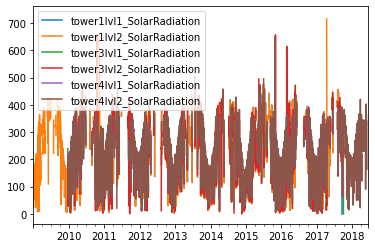

In [54]:
df_lst = [prep9,prep10,prep11,prep12,prep13,prep14]
for df in df_lst:
    df = threC(df,'SolarRadiation')
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 
prep.plot()

tower1lvl1_SolarRadiation
tower1lvl2_SolarRadiation
tower3lvl1_SolarRadiation
tower3lvl2_SolarRadiation
tower4lvl1_SolarRadiation
tower4lvl2_SolarRadiation


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

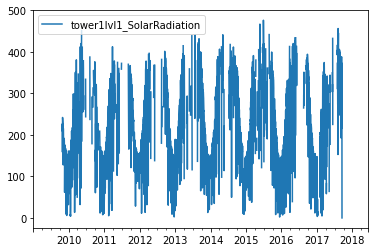

<Figure size 432x288 with 0 Axes>

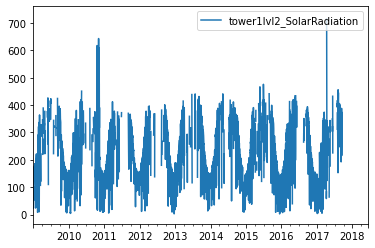

<Figure size 432x288 with 0 Axes>

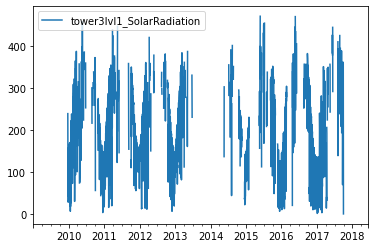

<Figure size 432x288 with 0 Axes>

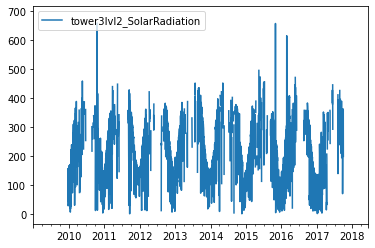

<Figure size 432x288 with 0 Axes>

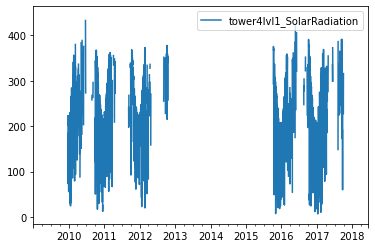

<Figure size 432x288 with 0 Axes>

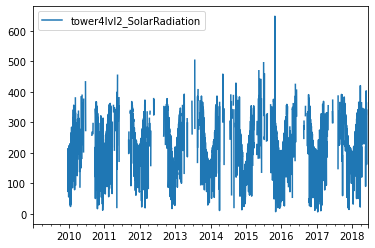

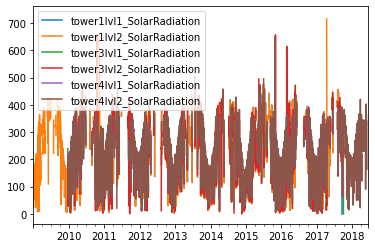

In [55]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SolarRadiation should be W/m2

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'SolarRadiation')  
SolarRadiation = copy.deepcopy(df)
SolarRadiation.plot()

### 5. Relative Humidity

In [56]:
prep14 = data14[['avgRH_t4_25']]
prep14.columns = ['tower4lvl2_RelativeHumidity_25ft']
prep14.head(2)

tower4lvl2_RelativeHumidity_25ft
DateTime                                             
2009-12-23 00:00:00                         69.767785
2009-12-23 01:00:00                         70.843416

In [57]:
prep13 = data13[['Rel Hum 25ft Sage4 [Sagehen4]']]
prep13.columns = ['tower4lvl1_RelativeHumidity_25ft']

In [58]:
prep12_1 = data12[['avgRH_t3_25']]
prep12_1.columns = ['tower3lvl2_RelativeHumidity_25ft']
prep12_1.head(2)
prep12_2 = data12[['avgRH_t3_100']]
prep12_2.columns = ['tower3lvl2_RelativeHumidity_100ft']
prep12_2.head(2)

tower3lvl2_RelativeHumidity_100ft
DateTime                                              
2009-12-23 00:00:00                          71.445068
2009-12-23 01:00:00                          72.525176

In [59]:
prep11_1 = data11[['Rel Hum 25ft Sage3 [Sagehen3]']]
prep11_1.columns = ['tower3lvl1_RelativeHumidity_25ft']

prep11_2 = data11[['Rel Hum 100ft Sage3 [Sagehen3]']]
prep11_2.columns = ['tower3lvl1_RelativeHumidity_100ft']


In [60]:
prep10_1 = data10[['RHall_t1_25']]
prep10_1.columns = ['tower1lvl2_RelativeHumidity_25ft']
prep10_1.head(2)
prep10_2 = data10[['RHall_t1_100']]
prep10_2.columns = ['tower1lvl2_RelativeHumidity_100ft']
prep10_2.head(2)

tower1lvl2_RelativeHumidity_100ft
DateTime                                              
2009-01-02 00:00:00                          97.908636
2009-01-02 01:00:00                          90.054196

In [61]:
prep9_1 = data9[['Rel Hum 25ft Sage1 [Sagehen1]']]
prep9_1.columns = ['tower1lvl1_RelativeHumidity_25ft']
prep9_1.head(2)

prep9_2 = data9[['Rel Hum 100ft Sage1 [Sagehen1]']]
prep9_2.columns = ['tower1lvl1_RelativeHumidity_100ft']
prep9_2.head(2)


tower1lvl1_RelativeHumidity_100ft
DateTime                                              
2009-10-27 10:00:00                          47.712000
2009-10-27 11:00:00                          42.933333

tower1lvl1_RelativeHumidity_25ft
DateTime                                             
2009-10-27 10:00:00                         48.322000
2009-10-27 11:00:00                         43.891667

(69111, 1)
2009-10-27 10:00:00 2017-09-15 00:00:00


tower1lvl1_RelativeHumidity_100ft
DateTime                                              
2009-10-27 10:00:00                          47.712000
2009-10-27 11:00:00                          42.933333

(69111, 1)
2009-10-27 10:00:00 2017-09-15 00:00:00


tower1lvl2_RelativeHumidity_25ft
DateTime                                             
2009-01-02 00:00:00                         91.344294
2009-01-02 01:00:00                         84.000659

(82741, 1)
2009-01-02 00:00:00 2018-06-11 12:00:00


tower1lvl2_RelativeHumidity_100ft
DateTime                                              
2009-01-02 00:00:00                          97.908636
2009-01-02 01:00:00                          90.054196

(82741, 1)
2009-01-02 00:00:00 2018-06-11 12:00:00


tower3lvl1_RelativeHumidity_25ft
DateTime                                             
2009-12-23 10:00:00                         35.980000
2009-12-23 11:00:00                         33.583333

(68103, 1)
2009-12-23 10:00:00 2017-09-30 00:00:00


tower3lvl1_RelativeHumidity_100ft
DateTime                                              
2009-12-23 10:00:00                          25.250000
2009-12-23 11:00:00                          27.261667

(68103, 1)
2009-12-23 10:00:00 2017-09-30 00:00:00


tower3lvl2_RelativeHumidity_25ft
DateTime                                             
2009-12-23 00:00:00                         82.656370
2009-12-23 01:00:00                         83.937774

(74221, 1)
2009-12-23 00:00:00 2018-06-11 12:00:00


tower3lvl2_RelativeHumidity_100ft
DateTime                                              
2009-12-23 00:00:00                          71.445068
2009-12-23 01:00:00                          72.525176

(74221, 1)
2009-12-23 00:00:00 2018-06-11 12:00:00


tower4lvl1_RelativeHumidity_25ft
DateTime                                             
2009-12-23 12:00:00                         17.875000
2009-12-23 13:00:00                         26.133333

(68124, 1)
2009-12-23 12:00:00 2017-09-30 23:00:00


tower4lvl2_RelativeHumidity_25ft
DateTime                                             
2009-12-23 00:00:00                         69.767785
2009-12-23 01:00:00                         70.843416

(74221, 1)
2009-12-23 00:00:00 2018-06-11 12:00:00
['tower1lvl1_RelativeHumidity_25ft', datetime.date(2009, 11, 13)]
nan ratio is 0.041666666666666664 , groupby value is 77.85536231869567
['tower1lvl1_RelativeHumidity_25ft', datetime.date(2010, 11, 16)]
nan ratio is 0.041666666666666664 , groupby value is 66.30898550695652
['tower1lvl1_RelativeHumidity_25ft', datetime.date(2013, 11, 15)]
nan ratio is 0.041666666666666664 , groupby value is 65.82273913086955
['tower1lvl1_RelativeHumidity_100ft', datetime.date(2009, 11, 13)]
nan ratio is 0.041666666666666664 , groupby value is 79.63188405782611
['tower1lvl1_RelativeHumidity_100ft', datetime.date(2010, 11, 16)]
nan ratio is 0.041666666666666664 , groupby value is 73.63884057869566
['tower1lvl1_RelativeHumidity_100ft', datetime.date(2013, 11, 15)]
nan ratio is 0.041666666666666664 , groupby value is 68.96362318782607
['tower1lvl2_RelativeHumidity_100ft', datetime.date(2009, 10, 13)]
nan ratio is 0.041666666666666664 , groupby value is 89.1

tower1lvl1_RelativeHumidity_25ft tower1lvl1_RelativeHumidity_100ft  \
2009-01-02                              NaN                               NaN   
2009-01-03                              NaN                               NaN   

           tower1lvl2_RelativeHumidity_25ft tower1lvl2_RelativeHumidity_100ft  \
2009-01-02                          87.0553                            91.746   
2009-01-03                          83.4442                           84.9579   

           tower3lvl1_RelativeHumidity_25ft tower3lvl1_RelativeHumidity_100ft  \
2009-01-02                              NaN                               NaN   
2009-01-03                              NaN                               NaN   

           tower3lvl2_RelativeHumidity_25ft tower3lvl2_RelativeHumidity_100ft  \
2009-01-02                              NaN                               NaN   
2009-01-03                              NaN                               NaN   

           tower4lvl1_RelativeHumidity_25ft tower4lvl2_RelativeHumidity_25ft  
2009-01-02                              NaN                              NaN  
2009-01-03                              NaN                              NaN

tower1lvl1_RelativeHumidity_25ft tower1lvl1_RelativeHumidity_100ft  \
2018-06-10                              NaN                               NaN   
2018-06-11                              NaN                               NaN   

           tower1lvl2_RelativeHumidity_25ft tower1lvl2_RelativeHumidity_100ft  \
2018-06-10                              NaN                               NaN   
2018-06-11                              NaN                               NaN   

           tower3lvl1_RelativeHumidity_25ft tower3lvl1_RelativeHumidity_100ft  \
2018-06-10                              NaN                               NaN   
2018-06-11                              NaN                               NaN   

           tower3lvl2_RelativeHumidity_25ft tower3lvl2_RelativeHumidity_100ft  \
2018-06-10                              NaN                               NaN   
2018-06-11                              NaN                               NaN   

           tower4lvl1_RelativeHumidity_25ft tower4lvl2_RelativeHumidity_25ft  
2018-06-10                              NaN                              NaN  
2018-06-11                              NaN                              NaN

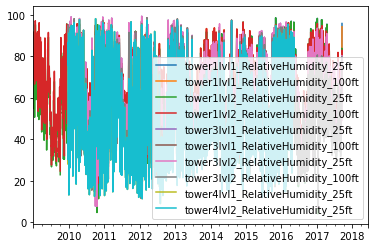

In [62]:
df_lst=[prep9_1,prep9_2,prep10_1,prep10_2,prep11_1,prep11_2,prep12_1,prep12_2,prep13,prep14]
for df in df_lst:
    df = threC(df,'RelativeHumidity')
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 
prep.plot()

tower1lvl1_RelativeHumidity_25ft
tower1lvl1_RelativeHumidity_100ft
tower1lvl2_RelativeHumidity_25ft
tower1lvl2_RelativeHumidity_100ft
tower3lvl1_RelativeHumidity_25ft
tower3lvl1_RelativeHumidity_100ft
tower3lvl2_RelativeHumidity_25ft
tower3lvl2_RelativeHumidity_100ft
tower4lvl1_RelativeHumidity_25ft
tower4lvl2_RelativeHumidity_25ft


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

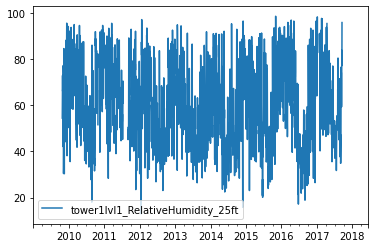

<Figure size 432x288 with 0 Axes>

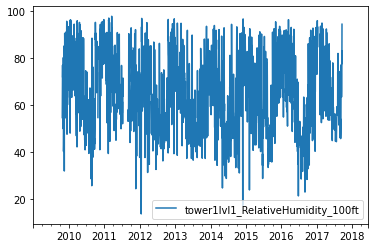

<Figure size 432x288 with 0 Axes>

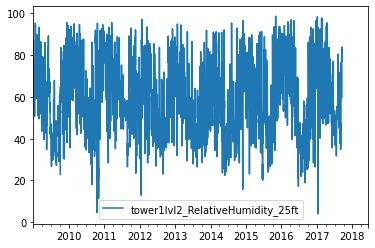

<Figure size 432x288 with 0 Axes>

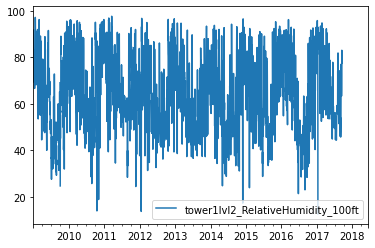

<Figure size 432x288 with 0 Axes>

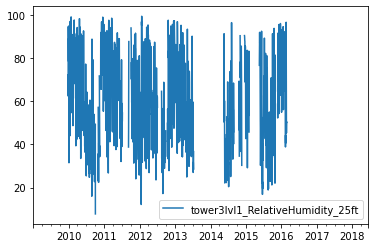

<Figure size 432x288 with 0 Axes>

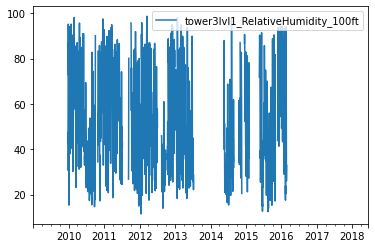

<Figure size 432x288 with 0 Axes>

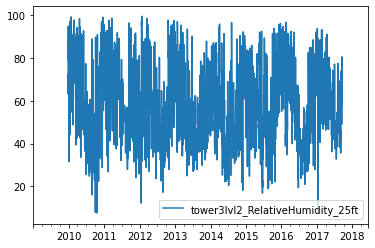

<Figure size 432x288 with 0 Axes>

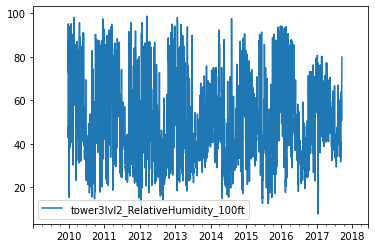

<Figure size 432x288 with 0 Axes>

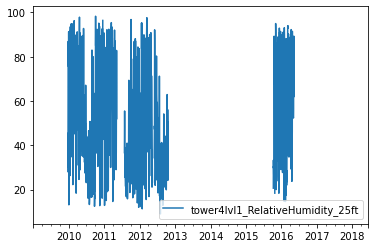

<Figure size 432x288 with 0 Axes>

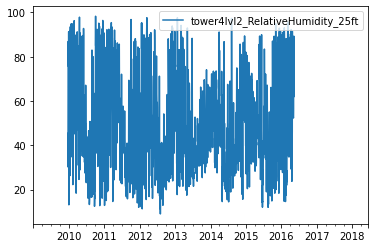

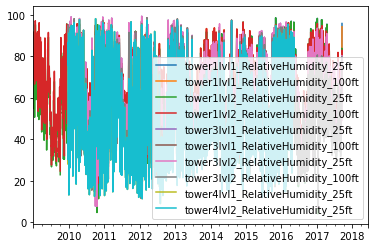

In [63]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! RelativeHumidity unit should be %

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'RelativeHumidity')  
RelativeHumidity = copy.deepcopy(df)
RelativeHumidity.plot()

### 6. WindDirection

### 7. WindSpeed

In [64]:
prep14_1 = data14[['avgws_ms_t4_25ft']]
prep14_1.columns = ['tower4lvl2_WindSpeed_25ft']

prep14_2 = data14[['avgws_ms_t4_100ft']]
prep14_2.columns = ['tower4lvl2_WindSpeed_100ft']

In [65]:
prep13_1 = data13[['Wind Spd MS 25ft Sage4 [Sagehen4]']]
prep13_1.columns = ['tower4lvl1_WindSpeed_25ft']

prep13_2 = data13[['Wind Spd MS 100ft Sage4 [Sagehen4]']]
prep13_2.columns = ['tower4lvl1_WindSpeed_100ft']

In [66]:
prep12_1 = data12[['avgws_ms_t3_25ft']]
prep12_1.columns = ['tower3lvl2_WindSpeed_25ft']

prep12_2 = data12[['avgws_ms_t3_100ft']]
prep12_2.columns = ['tower3lvl2_WindSpeed_100ft']

In [67]:
prep11_1 = data11[['Wind Spd MS 25ft Sage3 [Sagehen3]']]
prep11_1.columns = ['tower3lvl1_WindSpeed_25ft']

prep11_2 = data11[['Wind Spd MS 100ft Sage3 [Sagehen3]']]
prep11_2.columns = ['tower3lvl1_WindSpeed_100ft']

In [68]:
prep10 = data10[['avgws_ms_t1_100ft']]
prep10.columns = ['tower1lvl2_WindSpeed_100ft']
prep10.head(2)

tower1lvl2_WindSpeed_100ft
DateTime                                       
2009-01-02 00:00:00                         NaN
2009-01-02 01:00:00                         NaN

In [69]:
prep9 = data9[['Wind Spd MS 100ft Sage1 [Sagehen1]']]
prep9.columns = ['tower1lvl1_WindSpeed_100ft']
prep9.head(2)

tower1lvl1_WindSpeed_100ft
DateTime                                       
2009-10-27 10:00:00                         NaN
2009-10-27 11:00:00                         NaN

tower1lvl1_WindSpeed_100ft
DateTime                                       
2009-10-27 10:00:00                         NaN
2009-10-27 11:00:00                         NaN

(69111, 1)
2009-10-27 10:00:00 2017-09-15 00:00:00


tower1lvl2_WindSpeed_100ft
DateTime                                       
2009-01-02 00:00:00                         NaN
2009-01-02 01:00:00                         NaN

(82741, 1)
2009-01-02 00:00:00 2018-06-11 12:00:00


tower3lvl1_WindSpeed_25ft
DateTime                                      
2009-12-23 10:00:00                   0.383000
2009-12-23 11:00:00                   0.496333

(68103, 1)
2009-12-23 10:00:00 2017-09-30 00:00:00


tower3lvl1_WindSpeed_100ft
DateTime                                       
2009-12-23 10:00:00                    0.536000
2009-12-23 11:00:00                    1.371833

(68103, 1)
2009-12-23 10:00:00 2017-09-30 00:00:00


tower3lvl2_WindSpeed_25ft
DateTime                                      
2009-12-23 00:00:00                   0.783162
2009-12-23 01:00:00                   0.686763

(74221, 1)
2009-12-23 00:00:00 2018-06-11 12:00:00


tower3lvl2_WindSpeed_100ft
DateTime                                       
2009-12-23 00:00:00                    2.279012
2009-12-23 01:00:00                    1.993819

(74221, 1)
2009-12-23 00:00:00 2018-06-11 12:00:00


tower4lvl1_WindSpeed_25ft
DateTime                                      
2009-12-23 12:00:00                   0.755000
2009-12-23 13:00:00                   0.492667

(68124, 1)
2009-12-23 12:00:00 2017-09-30 23:00:00


tower4lvl1_WindSpeed_100ft
DateTime                                       
2009-12-23 12:00:00                         NaN
2009-12-23 13:00:00                         NaN

(68124, 1)
2009-12-23 12:00:00 2017-09-30 23:00:00


tower4lvl2_WindSpeed_25ft
DateTime                                      
2009-12-23 00:00:00                   1.882888
2009-12-23 01:00:00                   1.708107

(74221, 1)
2009-12-23 00:00:00 2018-06-11 12:00:00


tower4lvl2_WindSpeed_100ft
DateTime                                       
2009-12-23 00:00:00                    3.640587
2009-12-23 01:00:00                    3.364137

(74221, 1)
2009-12-23 00:00:00 2018-06-11 12:00:00
['tower3lvl1_WindSpeed_25ft', datetime.date(2010, 11, 1)]
nan ratio is 0.08333333333333333 , groupby value is 0.7121969696818182
['tower3lvl1_WindSpeed_25ft', datetime.date(2010, 11, 12)]
nan ratio is 0.041666666666666664 , groupby value is 0.636702898652174
['tower3lvl1_WindSpeed_25ft', datetime.date(2010, 11, 17)]
nan ratio is 0.08333333333333333 , groupby value is 1.1540643940000002
['tower3lvl1_WindSpeed_25ft', datetime.date(2010, 11, 27)]
nan ratio is 0.08333333333333333 , groupby value is 1.5116893940000002
['tower3lvl1_WindSpeed_25ft', datetime.date(2011, 9, 27)]
nan ratio is 0.041666666666666664 , groupby value is 0.7701920290000003
['tower3lvl1_WindSpeed_25ft', datetime.date(2012, 9, 25)]
nan ratio is 0.041666666666666664 , groupby value is 0.8295869565652173
['tower3lvl1_WindSpeed_25ft', datetime.date(2015, 2, 1)]
nan ratio is 0.08333333333333333 , groupby value is 0.7267727272727272
['tower3lvl1_WindSpeed_100ft', datetime.da

tower1lvl1_WindSpeed_100ft tower1lvl2_WindSpeed_100ft  \
2009-01-02                        NaN                        NaN   
2009-01-03                        NaN                        NaN   

           tower3lvl1_WindSpeed_25ft tower3lvl1_WindSpeed_100ft  \
2009-01-02                       NaN                        NaN   
2009-01-03                       NaN                        NaN   

           tower3lvl2_WindSpeed_25ft tower3lvl2_WindSpeed_100ft  \
2009-01-02                       NaN                        NaN   
2009-01-03                       NaN                        NaN   

           tower4lvl1_WindSpeed_25ft tower4lvl1_WindSpeed_100ft  \
2009-01-02                       NaN                        NaN   
2009-01-03                       NaN                        NaN   

           tower4lvl2_WindSpeed_25ft tower4lvl2_WindSpeed_100ft  
2009-01-02                       NaN                        NaN  
2009-01-03                       NaN                        NaN

tower1lvl1_WindSpeed_100ft tower1lvl2_WindSpeed_100ft  \
2018-06-10                        NaN                        NaN   
2018-06-11                        NaN                        NaN   

           tower3lvl1_WindSpeed_25ft tower3lvl1_WindSpeed_100ft  \
2018-06-10                       NaN                        NaN   
2018-06-11                       NaN                        NaN   

           tower3lvl2_WindSpeed_25ft tower3lvl2_WindSpeed_100ft  \
2018-06-10                       NaN                        NaN   
2018-06-11                       NaN                        NaN   

           tower4lvl1_WindSpeed_25ft tower4lvl1_WindSpeed_100ft  \
2018-06-10                       NaN                        NaN   
2018-06-11                       NaN                        NaN   

           tower4lvl2_WindSpeed_25ft tower4lvl2_WindSpeed_100ft  
2018-06-10                   1.26374                    2.44585  
2018-06-11                       NaN                        NaN

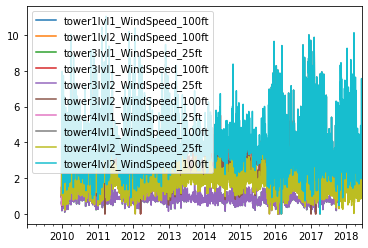

In [70]:
df_lst = [prep9,prep10,prep11_1,prep11_2,prep12_1,prep12_2,prep13_1,prep13_2,prep14_1,prep14_2]
for df in df_lst:
    df = threC(df,'WindSpeed')
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 
prep.plot()

tower1lvl1_WindSpeed_100ft
tower1lvl2_WindSpeed_100ft
tower3lvl1_WindSpeed_25ft
tower3lvl1_WindSpeed_100ft
tower3lvl2_WindSpeed_25ft
tower3lvl2_WindSpeed_100ft
tower4lvl1_WindSpeed_25ft
tower4lvl1_WindSpeed_100ft
tower4lvl2_WindSpeed_25ft
tower4lvl2_WindSpeed_100ft


tower1lvl1_WindSpeed_100ft  tower1lvl2_WindSpeed_100ft  \
2009-01-02                         NaN                         NaN   
2009-01-03                         NaN                         NaN   

            tower3lvl1_WindSpeed_25ft  tower3lvl1_WindSpeed_100ft  \
2009-01-02                        NaN                         NaN   
2009-01-03                        NaN                         NaN   

            tower3lvl2_WindSpeed_25ft  tower3lvl2_WindSpeed_100ft  \
2009-01-02                        NaN                         NaN   
2009-01-03                        NaN                         NaN   

            tower4lvl1_WindSpeed_25ft  tower4lvl1_WindSpeed_100ft  \
2009-01-02                        NaN                         NaN   
2009-01-03                        NaN                         NaN   

            tower4lvl2_WindSpeed_25ft  tower4lvl2_WindSpeed_100ft  
2009-01-02                        NaN                         NaN  
2009-01-03                        NaN                         NaN

<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

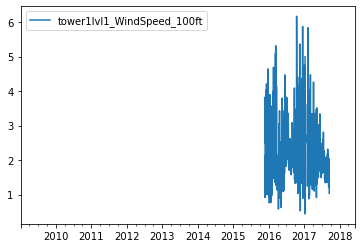

<Figure size 432x288 with 0 Axes>

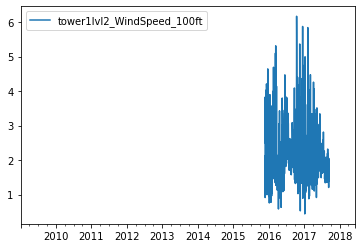

<Figure size 432x288 with 0 Axes>

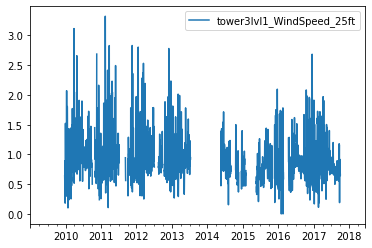

<Figure size 432x288 with 0 Axes>

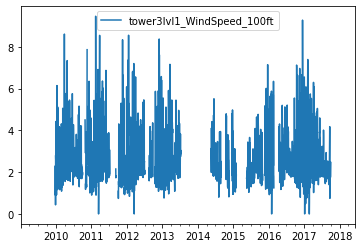

<Figure size 432x288 with 0 Axes>

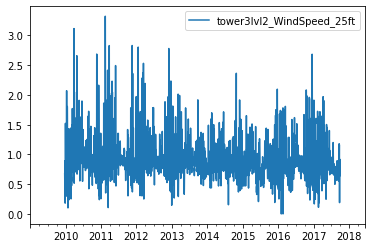

<Figure size 432x288 with 0 Axes>

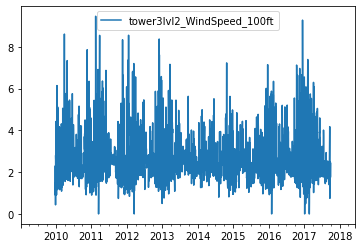

<Figure size 432x288 with 0 Axes>

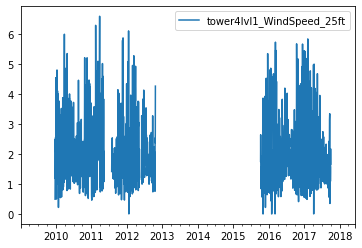

<Figure size 432x288 with 0 Axes>

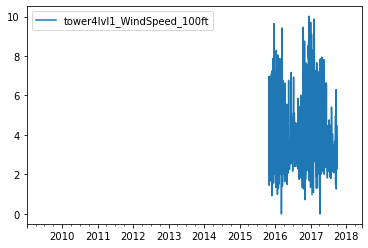

<Figure size 432x288 with 0 Axes>

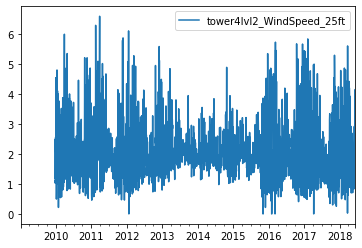

<Figure size 432x288 with 0 Axes>

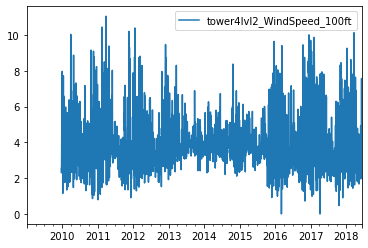

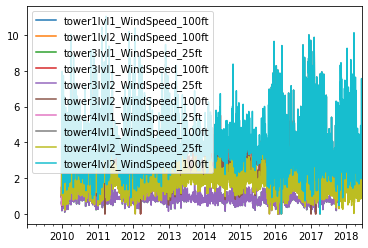

In [71]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! WindSpeed unit should be m/s

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'WindSpeed')  
WindSpeed = copy.deepcopy(df)
WindSpeed.plot()
WindSpeed.head(2)

### 8. SWE

In [72]:
prep6 = data6[['swe_mm_541']]
prep6.columns = ['541lvl2_SWE']
prep6.head(2)

541lvl2_SWE
DateTime               
1978-10-01          0.0
1978-10-02          0.0

In [73]:
prep5 = data5[['SWE (mm)']]
prep5.columns = ['541lvl1B_SWE']
prep5.head(2)

541lvl1B_SWE
DateTime                
1978-10-01             0
1978-10-02             0

In [74]:
prep4 = data4[['swe_mm_540']]
prep4.columns = ['540lvl2_SWE']
prep4.head(2)

540lvl2_SWE
DateTime               
1980-10-01          NaN
1980-10-02          NaN

In [75]:
prep3 = data3[['SWE (mm)']]
prep3.columns = ['540lvl1B_SWE']
prep3.head(2)

540lvl1B_SWE
DateTime                
1980-10-01           NaN
1980-10-02           NaN

In [76]:
prep2 = data2[['swe_mm_539']]
prep2.columns = ['539lvl2_SWE']
prep2.head(2)

539lvl2_SWE
DateTime               
1978-10-01          0.0
1978-10-02          0.0

In [77]:
prep1 = data1[['SWE (mm)']]
prep1.columns = ['539lvl1B_SWE']
prep1.head(2)

539lvl1B_SWE
DateTime                
1978-10-01             0
1978-10-02             0

541lvl2_SWE
DateTime               
1978-10-01          0.0
1978-10-02          0.0

(14499, 1)
1978-10-01 00:00:00 2018-06-11 00:00:00


541lvl1B_SWE
DateTime                
1978-10-01           0.0
1978-10-02           0.0

(14245, 1)
1978-10-01 00:00:00 2017-09-30 00:00:00


540lvl2_SWE
DateTime               
1980-10-01          NaN
1980-10-02          NaN

(13768, 1)
1980-10-01 00:00:00 NaT


540lvl1B_SWE
DateTime                
1980-10-01           NaN
1980-10-02           NaN

(13514, 1)
1980-10-01 00:00:00 2017-09-30 00:00:00


539lvl2_SWE
DateTime               
1978-10-01          0.0
1978-10-02          0.0

(14499, 1)
1978-10-01 00:00:00 2018-06-11 00:00:00


539lvl1B_SWE
DateTime                
1978-10-01           0.0
1978-10-02           0.0

(14245, 1)
1978-10-01 00:00:00 2017-09-30 00:00:00
The final table is:


541lvl2_SWE 541lvl1B_SWE 540lvl2_SWE 540lvl1B_SWE 539lvl2_SWE  \
1978-10-01           0            0         NaN          NaN           0   
1978-10-02           0            0         NaN          NaN           0   

           539lvl1B_SWE  
1978-10-01            0  
1978-10-02            0

541lvl2_SWE 541lvl1B_SWE 540lvl2_SWE 540lvl1B_SWE 539lvl2_SWE  \
2018-06-10         NaN          NaN         NaN          NaN         NaN   
2018-06-11         NaN          NaN         NaN          NaN         NaN   

           539lvl1B_SWE  
2018-06-10          NaN  
2018-06-11          NaN

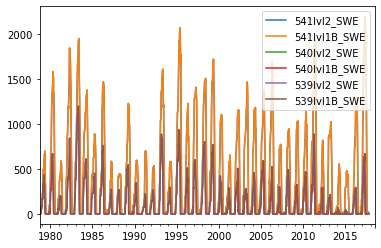

In [78]:
df_lst = [prep6,prep5,prep4,prep3,prep2,prep1]
for df in df_lst:
    df = threC(df,'SWE')
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 
prep.plot()

541lvl2_SWE
541lvl1B_SWE
540lvl2_SWE
540lvl1B_SWE
539lvl2_SWE
539lvl1B_SWE


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

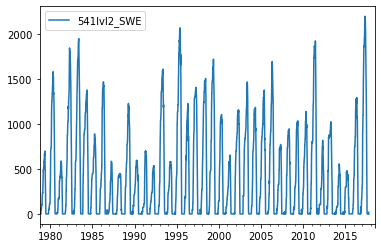

<Figure size 432x288 with 0 Axes>

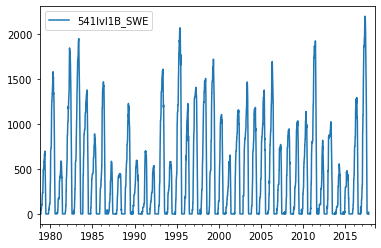

<Figure size 432x288 with 0 Axes>

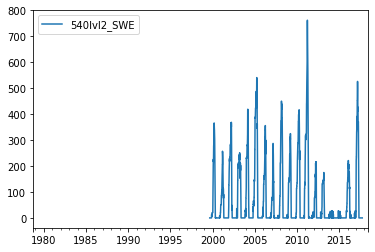

<Figure size 432x288 with 0 Axes>

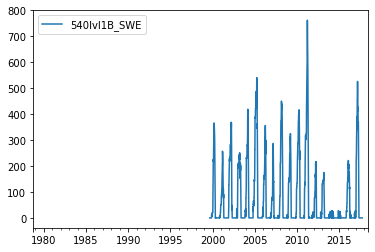

<Figure size 432x288 with 0 Axes>

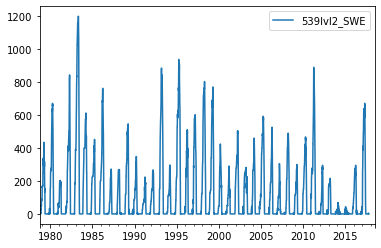

<Figure size 432x288 with 0 Axes>

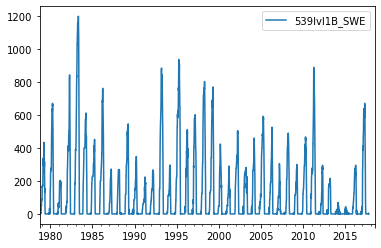

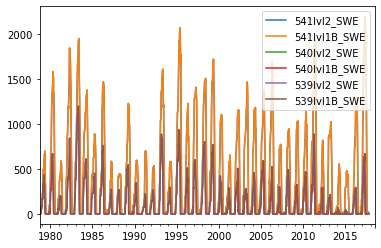

In [79]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! SWE unit should be mm

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit to mm
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'SWE')  
SWE = copy.deepcopy(df)
SWE.plot()

### 9. SnowDepth

In [80]:
prep8 = data8[['sd_cm_wrcc']]
prep8.columns = ['wrcclvl2_SnowDepth']
prep8.head(2)

wrcclvl2_SnowDepth
DateTime                      
1956-10-01                 0.0
1956-10-02                 0.0

In [81]:
prep7 = data7[['Snow Depth (cm)']]
prep7.columns = ['wrcclvl1B_SnowDepth']
prep7.head(2)

wrcclvl1B_SnowDepth
DateTime                       
1956-10-01                  0.0
1956-10-02                  0.0

In [82]:
prep6 = data6[['sd_cm_541']]
prep6.columns = ['541lvl2_SnowDepth']
prep6.head(2)

541lvl2_SnowDepth
DateTime                     
1978-10-01                NaN
1978-10-02                NaN

In [83]:
prep5 = data5[['Snow Depth (cm)']]
prep5.columns = ['541lvl1B_SnowDepth']
prep5.head(2)

541lvl1B_SnowDepth
DateTime                      
1978-10-01                 NaN
1978-10-02                 NaN

In [84]:
prep4 = data4[['sd_cm_540']]
prep4.columns = ['540lvl2_SnowDepth']
prep4.head(2)

540lvl2_SnowDepth
DateTime                     
1980-10-01                NaN
1980-10-02                NaN

In [85]:
prep3 = data3[['Snow Depth (cm)']]
prep3.columns = ['540lvl1B_SnowDepth']
prep3.head(2)

540lvl1B_SnowDepth
DateTime                      
1980-10-01                 NaN
1980-10-02                 NaN

In [86]:
prep2 = data2[['sd_cm_539']]
prep2.columns = ['539lvl2_SnowDepth']
prep2.head(2)

539lvl2_SnowDepth
DateTime                     
1978-10-01                NaN
1978-10-02                NaN

In [87]:
prep1 = data1[['Snow Depth (cm)']]
prep1.columns = ['539lvl1B_SnowDepth']
prep1.head(2)

539lvl1B_SnowDepth
DateTime                      
1978-10-01                 NaN
1978-10-02                 NaN

wrcclvl2_SnowDepth
DateTime                      
1956-10-01                 0.0
1956-10-02                 0.0

(18535, 1)
1956-10-01 00:00:00 2007-06-30 00:00:00


wrcclvl1B_SnowDepth
DateTime                       
1956-10-01                  0.0
1956-10-02                  0.0

(17926, 1)
1956-10-01 00:00:00 2007-06-30 00:00:00


541lvl2_SnowDepth
DateTime                     
1978-10-01                NaN
1978-10-02                NaN

(14499, 1)
1978-10-01 00:00:00 2018-06-11 00:00:00


541lvl1B_SnowDepth
DateTime                      
1978-10-01                 NaN
1978-10-02                 NaN

(14245, 1)
1978-10-01 00:00:00 2017-09-30 00:00:00


540lvl2_SnowDepth
DateTime                     
1980-10-01                NaN
1980-10-02                NaN

(13768, 1)
1980-10-01 00:00:00 NaT


540lvl1B_SnowDepth
DateTime                      
1980-10-01                 NaN
1980-10-02                 NaN

(13514, 1)
1980-10-01 00:00:00 2017-09-30 00:00:00


539lvl2_SnowDepth
DateTime                     
1978-10-01                NaN
1978-10-02                NaN

(14499, 1)
1978-10-01 00:00:00 2018-06-11 00:00:00


539lvl1B_SnowDepth
DateTime                      
1978-10-01                 NaN
1978-10-02                 NaN

(14245, 1)
1978-10-01 00:00:00 2017-09-30 00:00:00
The final table is:


wrcclvl2_SnowDepth wrcclvl1B_SnowDepth 541lvl2_SnowDepth  \
1956-10-01                  0                   0               NaN   
1956-10-02                  0                   0               NaN   

           541lvl1B_SnowDepth 540lvl2_SnowDepth 540lvl1B_SnowDepth  \
1956-10-01                NaN               NaN                NaN   
1956-10-02                NaN               NaN                NaN   

           539lvl2_SnowDepth 539lvl1B_SnowDepth  
1956-10-01               NaN                NaN  
1956-10-02               NaN                NaN

wrcclvl2_SnowDepth wrcclvl1B_SnowDepth 541lvl2_SnowDepth  \
2018-06-10                NaN                 NaN               NaN   
2018-06-11                NaN                 NaN               NaN   

           541lvl1B_SnowDepth 540lvl2_SnowDepth 540lvl1B_SnowDepth  \
2018-06-10                NaN               NaN                NaN   
2018-06-11                NaN               NaN                NaN   

           539lvl2_SnowDepth 539lvl1B_SnowDepth  
2018-06-10               NaN                NaN  
2018-06-11               NaN                NaN

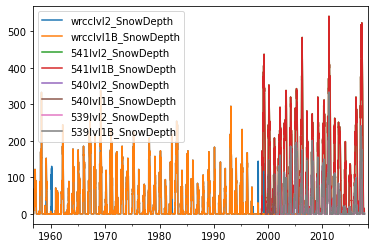

In [88]:
df_lst = [prep8,prep7,prep6,prep5,prep4,prep3,prep2,prep1]
for df in df_lst:
    df = threC(df,'SnowDepth')
    df.index = pd.to_datetime(df.index,errors = 'coerce')
    display(df.head(2))
    print(df.shape)
    print(df.index[0],df.index[-1])
prep = aggre_and_comb_daily(df_lst, axis=1, func = "mean") 
prep.plot()

wrcclvl2_SnowDepth
wrcclvl1B_SnowDepth
541lvl2_SnowDepth
541lvl1B_SnowDepth
540lvl2_SnowDepth
540lvl1B_SnowDepth
539lvl2_SnowDepth
539lvl1B_SnowDepth


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

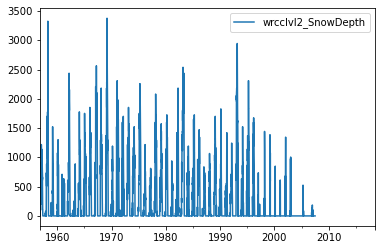

<Figure size 432x288 with 0 Axes>

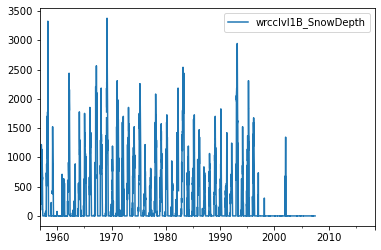

<Figure size 432x288 with 0 Axes>

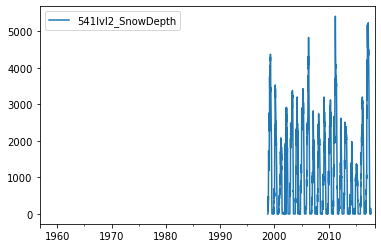

<Figure size 432x288 with 0 Axes>

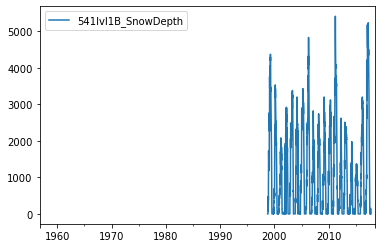

<Figure size 432x288 with 0 Axes>

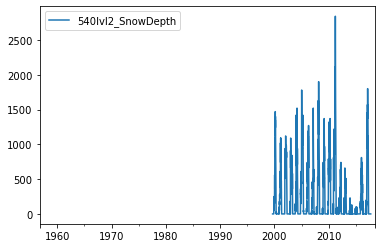

<Figure size 432x288 with 0 Axes>

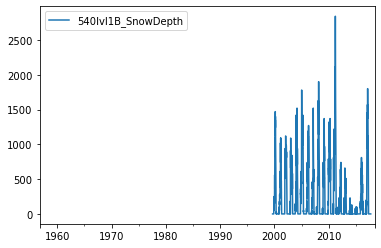

<Figure size 432x288 with 0 Axes>

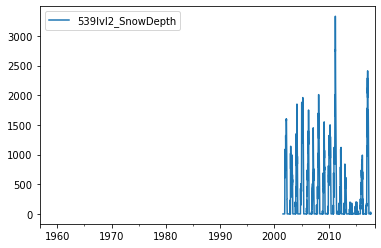

<Figure size 432x288 with 0 Axes>

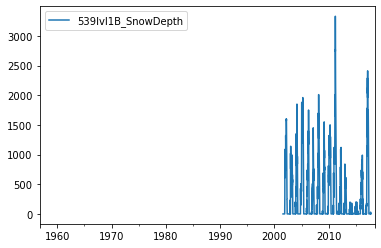

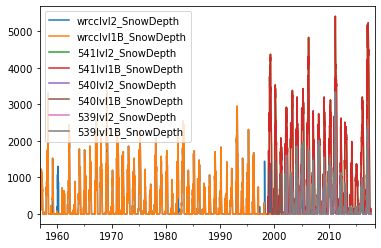

In [89]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Snowdepth unit should be mm

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*10  # convert to the right unit to mm
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'SnowDepth')  
SnowDepth = copy.deepcopy(df)
SnowDepth.plot()

### 10. Vapor Pressure

### 11. SoilMoisture

### 12. SoilTemperature

### 13. Isotope

### Combine the result

In [99]:
# Put all the tables to the same date format
# data_soil.index= pd.to_datetime(data_soil.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S
# data.index= pd.to_datetime(data.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S
# data_lwr.index= pd.to_datetime(data_lwr.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S
# Bring them together
result = pd.concat([Discharge, Precipitation,AirTemperature,RelativeHumidity, SolarRadiation, WindSpeed,SnowDepth,SWE],
                    axis=1,
                    join='outer')
result.index.rename('DateTime',inplace = True)
result.head()

Sagehen_Discharge  539lvl1B_Precipitation  539lvl2_Precipitation  \
DateTime                                                                       
1953-10-01             198.10                     NaN                    NaN   
1953-10-02              82.07                     NaN                    NaN   
1953-10-03              82.07                     NaN                    NaN   
1953-10-04              82.07                     NaN                    NaN   
1953-10-05              82.07                     NaN                    NaN   

            540lvlB_Precipitation  540lvl2_Precipitation  \
DateTime                                                   
1953-10-01                    NaN                    NaN   
1953-10-02                    NaN                    NaN   
1953-10-03                    NaN                    NaN   
1953-10-04                    NaN                    NaN   
1953-10-05                    NaN                    NaN   

            541lvlB_Precipitation  541lvl2_Precipitation  \
DateTime                                                   
1953-10-01                    NaN                    NaN   
1953-10-02                    NaN                    NaN   
1953-10-03                    NaN                    NaN   
1953-10-04                    NaN                    NaN   
1953-10-05                    NaN                    NaN   

            wrcclvl1B_Precipitation  wrcclvl2_Precipitation  \
DateTime                                                      
1953-10-01                      NaN                     NaN   
1953-10-02                      NaN                     NaN   
1953-10-03                      NaN                     NaN   
1953-10-04                      NaN                     NaN   
1953-10-05                      NaN                     NaN   

            539lvl1B_AirTemperature  ...  540lvl2_SnowDepth  \
DateTime                             ...                      
1953-10-01                      NaN  ...                NaN   
1953-10-02                      NaN  ...                NaN   
1953-10-03                      NaN  ...                NaN   
1953-10-04                      NaN  ...                NaN   
1953-10-05                      NaN  ...                NaN   

            540lvl1B_SnowDepth  539lvl2_SnowDepth  539lvl1B_SnowDepth  \
DateTime                                                                
1953-10-01                 NaN                NaN                 NaN   
1953-10-02                 NaN                NaN                 NaN   
1953-10-03                 NaN                NaN                 NaN   
1953-10-04                 NaN                NaN                 NaN   
1953-10-05                 NaN                NaN                 NaN   

            541lvl2_SWE  541lvl1B_SWE  540lvl2_SWE  540lvl1B_SWE  539lvl2_SWE  \
DateTime                                                                        
1953-10-01          NaN           NaN          NaN           NaN          NaN   
1953-10-02          NaN           NaN          NaN           NaN          NaN   
1953-10-03          NaN           NaN          NaN           NaN          NaN   
1953-10-04          NaN           NaN          NaN           NaN          NaN   
1953-10-05          NaN           NaN          NaN           NaN          NaN   

            539lvl1B_SWE  
DateTime                  
1953-10-01           NaN  
1953-10-02           NaN  
1953-10-03           NaN  
1953-10-04           NaN  
1953-10-05           NaN  

[5 rows x 69 columns]

In [100]:
result.tail()

Sagehen_Discharge  539lvl1B_Precipitation  539lvl2_Precipitation  \
DateTime                                                                       
2020-12-27             60.562                     NaN                    NaN   
2020-12-28             60.562                     NaN                    NaN   
2020-12-29             60.562                     NaN                    NaN   
2020-12-30             60.279                     NaN                    NaN   
2020-12-31             60.845                     NaN                    NaN   

            540lvlB_Precipitation  540lvl2_Precipitation  \
DateTime                                                   
2020-12-27                    NaN                    NaN   
2020-12-28                    NaN                    NaN   
2020-12-29                    NaN                    NaN   
2020-12-30                    NaN                    NaN   
2020-12-31                    NaN                    NaN   

            541lvlB_Precipitation  541lvl2_Precipitation  \
DateTime                                                   
2020-12-27                    NaN                    NaN   
2020-12-28                    NaN                    NaN   
2020-12-29                    NaN                    NaN   
2020-12-30                    NaN                    NaN   
2020-12-31                    NaN                    NaN   

            wrcclvl1B_Precipitation  wrcclvl2_Precipitation  \
DateTime                                                      
2020-12-27                      NaN                     NaN   
2020-12-28                      NaN                     NaN   
2020-12-29                      NaN                     NaN   
2020-12-30                      NaN                     NaN   
2020-12-31                      NaN                     NaN   

            539lvl1B_AirTemperature  ...  540lvl2_SnowDepth  \
DateTime                             ...                      
2020-12-27                      NaN  ...                NaN   
2020-12-28                      NaN  ...                NaN   
2020-12-29                      NaN  ...                NaN   
2020-12-30                      NaN  ...                NaN   
2020-12-31                      NaN  ...                NaN   

            540lvl1B_SnowDepth  539lvl2_SnowDepth  539lvl1B_SnowDepth  \
DateTime                                                                
2020-12-27                 NaN                NaN                 NaN   
2020-12-28                 NaN                NaN                 NaN   
2020-12-29                 NaN                NaN                 NaN   
2020-12-30                 NaN                NaN                 NaN   
2020-12-31                 NaN                NaN                 NaN   

            541lvl2_SWE  541lvl1B_SWE  540lvl2_SWE  540lvl1B_SWE  539lvl2_SWE  \
DateTime                                                                        
2020-12-27          NaN           NaN          NaN           NaN          NaN   
2020-12-28          NaN           NaN          NaN           NaN          NaN   
2020-12-29          NaN           NaN          NaN           NaN          NaN   
2020-12-30          NaN           NaN          NaN           NaN          NaN   
2020-12-31          NaN           NaN          NaN           NaN          NaN   

            539lvl1B_SWE  
DateTime                  
2020-12-27           NaN  
2020-12-28           NaN  
2020-12-29           NaN  
2020-12-30           NaN  
2020-12-31           NaN  

[5 rows x 69 columns]

In [101]:
result.columns

Index(['Sagehen_Discharge', '539lvl1B_Precipitation', '539lvl2_Precipitation',
       '540lvlB_Precipitation', '540lvl2_Precipitation',
       '541lvlB_Precipitation', '541lvl2_Precipitation',
       'wrcclvl1B_Precipitation', 'wrcclvl2_Precipitation',
       '539lvl1B_AirTemperature', '539lvl2_AirTemperature',
       '540lvl1B_AirTemperature', '540lvl2_AirTemperature',
       '541lvl1B_AirTemperature', '541lvl2_AirTemperature',
       'wrcclvl1B_AirTemperature', 'wrcclvl2_AirTemperature',
       'tower1lvl1_AirTemperature_100ft', 'tower1lvl1_AirTemperature_25ft',
       'tower1lvl2_AirTemperature_25ft', 'tower1lvl2_AirTemperature_100ft',
       'tower3lvl1_AirTemperature_25ft', 'tower3lvl1_AirTemperature_100ft',
       'tower3lvl2_AirTemperature_25ft', 'tower3lvl2_AirTemperature_100ft',
       'tower4lvl1_AirTemperature_25ft', 'tower4lvl1_AirTemperature_100ft',
       'tower4lvl2_AirTemperature_25ft', 'tower4lvl2_AirTemperature_100ft',
       'tower1lvl1_RelativeHumidity_25ft', 'tower

In [102]:
# Write data to csv for further inspection
result.to_csv('1_'+watershed+'_Download_Aggregation_Daily.csv', sep=',')